# **Parameter Efficient Fine Tuning using LoRA adapter**

Paper being referred: "*LORA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS*" (https://arxiv.org/pdf/2106.09685.pdf)

In [1]:
# Mount into drive

from google.colab import drive

drive.mount("/content/drive")

# Change directory to the package folder
#!! This should be the base directory of the project, this directory should look like the screenshot below.

%cd '/content/drive/MyDrive/DL/project/'

# Verify the contents of the current folder
!ls

Mounted at /content/drive
/content/drive/MyDrive/DL/project
datafiles  notebooks  Results


# Set-up directories properly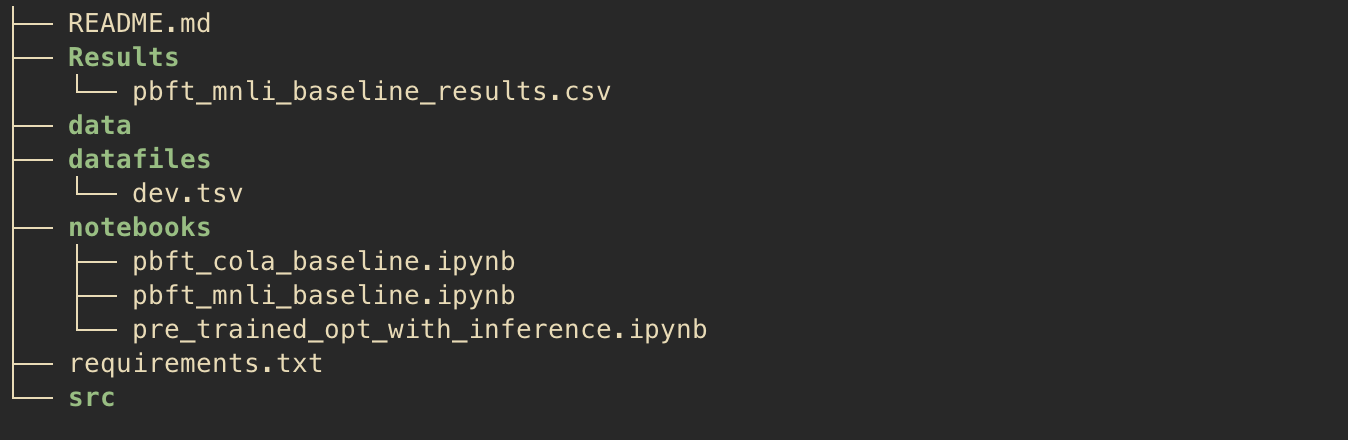

In [2]:
import os

from requests import get
from socket import gethostname, gethostbyname
ip = gethostbyname(gethostname())
curr_filename = get(f"http://{ip}:9000/api/sessions").json()[0]["name"]

# if there is no notebooks folder, create one and move the notebook to that folder and cd into it
if not os.path.exists('notebooks'):
  %mkdir notebooks
  %mv curr_filename notebooks/

%cd notebooks/

# check if "Results" folder exits in the base directly, else create one
if not os.path.exists('../Results'):
  %mkdir ../Results

!ls


/content/drive/MyDrive/DL/project/notebooks
pbft_cola_baseline.ipynb  peft_LoRA_on_cola.ipynb  pre_trained_opt.ipynb  results


In [3]:
!pip install -q transformers accelerate bitsandbytes datasets torch peft tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 43.8 MB/s eta 0:00:00


In [4]:
# Load required libraries

from datasets import load_dataset, ClassLabel
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, AdamW, AutoConfig
from peft import LoraConfig, get_peft_model
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

In [5]:
# Set seed, load COLA dataset

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

in_domain_data = load_dataset("glue", "cola") # COLA dataset (labels: (1) acceptable (2) not acceptable)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

# **Pre-processing code and function definitions**

In [6]:
# Deifine model and tokenizer

# Define the tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m")


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

In [7]:
# Function to load and parse out-of-domain COLA dataset
'''
\cite: https://github.com/uds-lsv/llmft/blob/main/task_utils.py
'''
def load_cola_ood_dataset(path, label=None, cache_dir=None):
    data_files = {"validation": path}
    dataset = load_dataset("csv", data_files=data_files, sep="\t", column_names=[
                           'code', 'label', 'annotation', 'sentence'], cache_dir=cache_dir)
    dataset = dataset["validation"]

    # cola-ood comes without indices, so we add them
    indices = list(range(len(dataset)))
    dataset = dataset.add_column(name="idx", column=indices)

    subset = "cola-ood"

    if label is not None:  # filter dataset based on label
        dataset = dataset.filter(
            lambda example: example["label"] == label)
        subset = f"{subset}-{'acceptable' if label == 1 else 'unacceptable'}"

    return dataset, subset

In [8]:
# Deifne function for computing metric

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


In [9]:
# Manipulate data for decoder part of the model and add prompts relevant for CoLA

def manipulate_inputs_for_cola_with_prompt(inputs):
    # Add pattern/prompts
    inputs = tokenizer(["Yes or No?" + sentence for sentence in inputs["sentence"]], truncation=True, padding="max_length", max_length=128)

    return inputs

# augment in-domain-data
in_domain_data = in_domain_data.map(manipulate_inputs_for_cola_with_prompt, batched=True)

# augment out of domain data
eval_ood_data, _ = load_cola_ood_dataset(path='../datafiles/dev.tsv')
eval_ood_data = eval_ood_data.map(manipulate_inputs_for_cola_with_prompt, batched=True)

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

In [10]:
# Define parameters for training experiments (per reference paper)

few_shot_sample_size = [2, 16, 32, 64, 128]  # number of examples for each class
num_epochs = 40
batch_size = 32
learning_rate = 1e-5
weight_decay = 0.
warmup_ratio = 0.1
num_runs = 10

In [11]:
# Vaiables to store training results into CSV
results_df = pd.DataFrame(columns=["n", "rank", "run", "in_domain_accuracy", "out_of_domain_accuracy"])

In [12]:
# deine config for LoRA
# !note - params set per paper for varying ranks of the marices
lora_config_r1 = LoraConfig(r=1, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)
lora_config_r2 = LoraConfig(r=2, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)
lora_config_r4 = LoraConfig(r=4, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)
lora_config_r8 = LoraConfig(r=8, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)
lora_config_r64 = LoraConfig(r=64, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)

lora_configs = [lora_config_r1, lora_config_r2, lora_config_r4, lora_config_r8, lora_config_r64]

# **Experimentation loop**

In [13]:
for _, n in enumerate(tqdm(few_shot_sample_size)):
    for _, lora_config in enumerate(tqdm(lora_configs)):
      for run_idx in tqdm(range(num_runs)):  # repeat 10 times for each n
          # re-iniialize model for each run
          model = AutoModelForSequenceClassification.from_pretrained("facebook/opt-125m")
          model = get_peft_model(model, lora_config)
          optimizer = AdamW(model.parameters(), lr=learning_rate)

          # Select n random examples for each class from the original data
          indices_yes = np.where(np.array(in_domain_data["train"]["label"]) == 0)[0]
          indices_no = np.where(np.array(in_domain_data["train"]["label"]) == 1)[0]
          indices_yes = np.random.choice(indices_yes, n, replace=False)
          indices_no = np.random.choice(indices_no, n, replace=False)
          indices = np.concatenate([indices_yes, indices_no])

          # Select the examples for the new training set
          train_dataset = in_domain_data["train"].select(indices)

          # Define training config
          # Total steps = (#samples/batch size) * epochs
          total_steps = (len(train_dataset) // batch_size) * num_epochs

          training_args = TrainingArguments(
              output_dir = "./results",
              overwrite_output_dir = True,
              num_train_epochs = num_epochs,
              per_device_train_batch_size = batch_size,
              learning_rate = learning_rate,
              weight_decay = weight_decay,
              save_steps = 10_000,
              save_total_limit = 2,
              warmup_steps = int(warmup_ratio * total_steps),
          )

          # Define the trainer
          trainer = Trainer(
              model = model,
              args=training_args,
              train_dataset = train_dataset,
              compute_metrics = compute_metrics,
              optimizers=(optimizer, None),
          )

          # Train the model
          trainer.train()

          # Evaluate in-domain performance
          print(f"Evaluating in-domain performance for n={n}, rank={lora_config.r}...")
          eval_results = trainer.evaluate(eval_dataset=in_domain_data["validation"])

          # Store the in-domain accuracy
          in_domain_accuracy = eval_results["eval_accuracy"]

          # Print the in-domain evaluation results
          for key, value in eval_results.items():
              print(f"In-domain {key}: {value}")

          # Evaluate out-of-domain performance
          print(f"Evaluating out-of-domain performance for n={n}, rank={lora_config.r}...")
          eval_results = trainer.evaluate(eval_dataset=eval_ood_data)

          # Store the out-of-domain accuracy
          out_of_domain_accuracy = eval_results["eval_accuracy"]

          # Print the out-of-domain evaluation results
          for key, value in eval_results.items():
              print(f"Out-of-domain {key}: {value}")

          # Add the results to the DataFrame
          new_row = pd.DataFrame({
              "n": [n],
              "rank": [lora_config.r],
              "run": [run_idx],
              "in_domain_accuracy": [in_domain_accuracy],
              "out_of_domain_accuracy": [out_of_domain_accuracy]
          })
          results_df = pd.concat([results_df, new_row], ignore_index=True)

print(f'Finished training!!')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=1...


In-domain eval_loss: 0.7648054957389832
In-domain eval_accuracy: 0.6893576222435283
In-domain eval_runtime: 3.4189
In-domain eval_samples_per_second: 305.069
In-domain eval_steps_per_second: 38.316
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=1...




 10%|█         | 1/10 [00:14<02:09, 14.34s/it]

Out-of-domain eval_loss: 0.7862328886985779
Out-of-domain eval_accuracy: 0.686046511627907
Out-of-domain eval_runtime: 1.749
Out-of-domain eval_samples_per_second: 295.028
Out-of-domain eval_steps_per_second: 37.164
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=1...


In-domain eval_loss: 0.7540538907051086
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.3959
In-domain eval_samples_per_second: 307.135
In-domain eval_steps_per_second: 38.576
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=1...




 20%|██        | 2/10 [00:21<01:23, 10.39s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7402976155281067
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.745
Out-of-domain eval_samples_per_second: 295.709
Out-of-domain eval_steps_per_second: 37.25
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=1...


In-domain eval_loss: 0.7540538907051086
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.3997
In-domain eval_samples_per_second: 306.796
In-domain eval_steps_per_second: 38.533
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=1...




 30%|███       | 3/10 [00:29<01:03,  9.13s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7402976155281067
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.7491
Out-of-domain eval_samples_per_second: 295.004
Out-of-domain eval_steps_per_second: 37.161
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=1...


In-domain eval_loss: 0.7540538907051086
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.4429
In-domain eval_samples_per_second: 302.939
In-domain eval_steps_per_second: 38.049
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=1...




 40%|████      | 4/10 [00:37<00:51,  8.56s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7402976155281067
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.7568
Out-of-domain eval_samples_per_second: 293.714
Out-of-domain eval_steps_per_second: 36.999
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=1...


In-domain eval_loss: 0.7540538907051086
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.4782
In-domain eval_samples_per_second: 299.869
In-domain eval_steps_per_second: 37.663
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=1...




 50%|█████     | 5/10 [00:45<00:41,  8.27s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7402976155281067
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.7842
Out-of-domain eval_samples_per_second: 289.203
Out-of-domain eval_steps_per_second: 36.431
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=1...


In-domain eval_loss: 0.7540538907051086
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.4871
In-domain eval_samples_per_second: 299.099
In-domain eval_steps_per_second: 37.567
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=1...




 60%|██████    | 6/10 [00:52<00:32,  8.09s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7402976155281067
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.7962
Out-of-domain eval_samples_per_second: 287.277
Out-of-domain eval_steps_per_second: 36.188
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=1...


In-domain eval_loss: 0.7540538907051086
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.5393
In-domain eval_samples_per_second: 294.691
In-domain eval_steps_per_second: 37.013
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=1...




 70%|███████   | 7/10 [01:00<00:24,  8.01s/it]

Out-of-domain eval_loss: 0.7402976155281067
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8015
Out-of-domain eval_samples_per_second: 286.429
Out-of-domain eval_steps_per_second: 36.081
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=1...


In-domain eval_loss: 0.7540538907051086
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.5541
In-domain eval_samples_per_second: 293.462
In-domain eval_steps_per_second: 36.859
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=1...




 80%|████████  | 8/10 [01:08<00:15,  7.97s/it]

Out-of-domain eval_loss: 0.7402976155281067
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8096
Out-of-domain eval_samples_per_second: 285.153
Out-of-domain eval_steps_per_second: 35.92
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=1...


In-domain eval_loss: 0.7540538907051086
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.5999
In-domain eval_samples_per_second: 289.734
In-domain eval_steps_per_second: 36.39
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=1...




 90%|█████████ | 9/10 [01:16<00:08,  8.03s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7402976155281067
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8359
Out-of-domain eval_samples_per_second: 281.061
Out-of-domain eval_steps_per_second: 35.405
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=1...


In-domain eval_loss: 0.7540538907051086
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.5886
In-domain eval_samples_per_second: 290.646
In-domain eval_steps_per_second: 36.505
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=1...




100%|██████████| 10/10 [01:24<00:00,  8.45s/it]

 20%|██        | 1/5 [01:24<05:38, 84.53s/it]

Out-of-domain eval_loss: 0.7402976155281067
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8243
Out-of-domain eval_samples_per_second: 282.845
Out-of-domain eval_steps_per_second: 35.63
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=2, rank=2...


In-domain eval_loss: 0.7513619065284729
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6705
In-domain eval_samples_per_second: 284.157
In-domain eval_steps_per_second: 35.69
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=2...




 10%|█         | 1/10 [00:08<01:13,  8.14s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377377152442932
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.873
Out-of-domain eval_samples_per_second: 275.499
Out-of-domain eval_steps_per_second: 34.704
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=2...


In-domain eval_loss: 0.7513619065284729
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6709
In-domain eval_samples_per_second: 284.128
In-domain eval_steps_per_second: 35.686
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=2...




 20%|██        | 2/10 [00:16<01:04,  8.08s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377377152442932
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8825
Out-of-domain eval_samples_per_second: 274.102
Out-of-domain eval_steps_per_second: 34.528
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=2...


In-domain eval_loss: 0.7513619065284729
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6897
In-domain eval_samples_per_second: 282.676
In-domain eval_steps_per_second: 35.504
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=2...




 30%|███       | 3/10 [00:24<00:56,  8.08s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377377152442932
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8777
Out-of-domain eval_samples_per_second: 274.811
Out-of-domain eval_steps_per_second: 34.618
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=2...


In-domain eval_loss: 0.7513619065284729
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6603
In-domain eval_samples_per_second: 284.952
In-domain eval_steps_per_second: 35.79
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=2...




 40%|████      | 4/10 [00:32<00:48,  8.05s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377377152442932
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.881
Out-of-domain eval_samples_per_second: 274.317
Out-of-domain eval_steps_per_second: 34.555
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=2...


In-domain eval_loss: 0.7513619065284729
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6515
In-domain eval_samples_per_second: 285.639
In-domain eval_steps_per_second: 35.876
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=2...




 50%|█████     | 5/10 [00:40<00:40,  8.02s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377377152442932
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8508
Out-of-domain eval_samples_per_second: 278.793
Out-of-domain eval_steps_per_second: 35.119
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=2...


In-domain eval_loss: 0.7513619065284729
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6198
In-domain eval_samples_per_second: 288.138
In-domain eval_steps_per_second: 36.19
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=2...




 60%|██████    | 6/10 [00:48<00:31,  8.00s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377377152442932
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8631
Out-of-domain eval_samples_per_second: 276.96
Out-of-domain eval_steps_per_second: 34.888
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=2...


In-domain eval_loss: 0.7513619065284729
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6382
In-domain eval_samples_per_second: 286.682
In-domain eval_steps_per_second: 36.007
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=2...




 70%|███████   | 7/10 [00:56<00:23,  7.98s/it]

Out-of-domain eval_loss: 0.7377377152442932
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8523
Out-of-domain eval_samples_per_second: 278.57
Out-of-domain eval_steps_per_second: 35.091
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=2...


In-domain eval_loss: 0.7513619065284729
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6007
In-domain eval_samples_per_second: 289.666
In-domain eval_steps_per_second: 36.382
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=2...




 80%|████████  | 8/10 [01:04<00:15,  7.97s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377377152442932
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.854
Out-of-domain eval_samples_per_second: 278.319
Out-of-domain eval_steps_per_second: 35.06
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=2...


In-domain eval_loss: 0.7513619065284729
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6444
In-domain eval_samples_per_second: 286.195
In-domain eval_steps_per_second: 35.946
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=2...




 90%|█████████ | 9/10 [01:12<00:07,  7.97s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377377152442932
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8565
Out-of-domain eval_samples_per_second: 277.941
Out-of-domain eval_steps_per_second: 35.012
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=2...


In-domain eval_loss: 0.7513619065284729
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6085
In-domain eval_samples_per_second: 289.04
In-domain eval_steps_per_second: 36.303
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=2...




100%|██████████| 10/10 [01:20<00:00,  8.00s/it]

 40%|████      | 2/5 [02:44<04:05, 81.89s/it]

Out-of-domain eval_loss: 0.7377377152442932
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8651
Out-of-domain eval_samples_per_second: 276.667
Out-of-domain eval_steps_per_second: 34.851
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.7515831589698792
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6464
In-domain eval_samples_per_second: 286.035
In-domain eval_steps_per_second: 35.926
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




 10%|█         | 1/10 [00:07<01:11,  8.00s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7378385066986084
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.866
Out-of-domain eval_samples_per_second: 276.531
Out-of-domain eval_steps_per_second: 34.834
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.7515831589698792
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6371
In-domain eval_samples_per_second: 286.765
In-domain eval_steps_per_second: 36.017
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




 20%|██        | 2/10 [00:15<01:03,  8.00s/it]

Out-of-domain eval_loss: 0.7378385066986084
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8602
Out-of-domain eval_samples_per_second: 277.391
Out-of-domain eval_steps_per_second: 34.943
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.7515831589698792
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6635
In-domain eval_samples_per_second: 284.698
In-domain eval_steps_per_second: 35.758
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




 30%|███       | 3/10 [00:24<00:56,  8.03s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7378385066986084
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.878
Out-of-domain eval_samples_per_second: 274.755
Out-of-domain eval_steps_per_second: 34.611
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.7515831589698792
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6425
In-domain eval_samples_per_second: 286.345
In-domain eval_steps_per_second: 35.965
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




 40%|████      | 4/10 [00:32<00:48,  8.01s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7378385066986084
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8619
Out-of-domain eval_samples_per_second: 277.139
Out-of-domain eval_steps_per_second: 34.911
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.7515831589698792
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6767
In-domain eval_samples_per_second: 283.682
In-domain eval_steps_per_second: 35.63
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




 50%|█████     | 5/10 [00:40<00:40,  8.01s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7378385066986084
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.867
Out-of-domain eval_samples_per_second: 276.379
Out-of-domain eval_steps_per_second: 34.815
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.7515831589698792
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.662
In-domain eval_samples_per_second: 284.816
In-domain eval_steps_per_second: 35.773
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




 60%|██████    | 6/10 [00:48<00:32,  8.02s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7378385066986084
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8844
Out-of-domain eval_samples_per_second: 273.827
Out-of-domain eval_steps_per_second: 34.494
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.7515831589698792
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6516
In-domain eval_samples_per_second: 285.628
In-domain eval_steps_per_second: 35.875
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




 70%|███████   | 7/10 [00:56<00:24,  8.01s/it]

Out-of-domain eval_loss: 0.7378385066986084
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8426
Out-of-domain eval_samples_per_second: 280.035
Out-of-domain eval_steps_per_second: 35.276
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.7515831589698792
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.644
In-domain eval_samples_per_second: 286.224
In-domain eval_steps_per_second: 35.95
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




 80%|████████  | 8/10 [01:04<00:16,  8.00s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7378385066986084
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8483
Out-of-domain eval_samples_per_second: 279.176
Out-of-domain eval_steps_per_second: 35.168
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.7515831589698792
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6489
In-domain eval_samples_per_second: 285.838
In-domain eval_steps_per_second: 35.901
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




 90%|█████████ | 9/10 [01:12<00:07,  7.99s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7378385066986084
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8626
Out-of-domain eval_samples_per_second: 277.039
Out-of-domain eval_steps_per_second: 34.898
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.7515831589698792
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6587
In-domain eval_samples_per_second: 285.074
In-domain eval_steps_per_second: 35.805
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




100%|██████████| 10/10 [01:20<00:00,  8.01s/it]

 60%|██████    | 3/5 [04:04<02:42, 81.06s/it]

Out-of-domain eval_loss: 0.7378385066986084
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8521
Out-of-domain eval_samples_per_second: 278.597
Out-of-domain eval_steps_per_second: 35.095
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=2, rank=8...


In-domain eval_loss: 0.751838207244873
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6368
In-domain eval_samples_per_second: 286.793
In-domain eval_steps_per_second: 36.021
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=8...




 10%|█         | 1/10 [00:08<01:12,  8.02s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7381227612495422
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.856
Out-of-domain eval_samples_per_second: 278.018
Out-of-domain eval_steps_per_second: 35.022
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=8...


In-domain eval_loss: 0.751838207244873
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6741
In-domain eval_samples_per_second: 283.882
In-domain eval_steps_per_second: 35.655
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=8...




 20%|██        | 2/10 [00:16<01:04,  8.06s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7381227612495422
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.9036
Out-of-domain eval_samples_per_second: 271.07
Out-of-domain eval_steps_per_second: 34.146
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=8...


In-domain eval_loss: 0.751838207244873
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6676
In-domain eval_samples_per_second: 284.384
In-domain eval_steps_per_second: 35.718
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=8...




 30%|███       | 3/10 [00:24<00:56,  8.06s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7381227612495422
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.875
Out-of-domain eval_samples_per_second: 275.205
Out-of-domain eval_steps_per_second: 34.667
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=8...


In-domain eval_loss: 0.751838207244873
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6402
In-domain eval_samples_per_second: 286.52
In-domain eval_steps_per_second: 35.987
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=8...




 40%|████      | 4/10 [00:32<00:48,  8.04s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7381227612495422
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8465
Out-of-domain eval_samples_per_second: 279.449
Out-of-domain eval_steps_per_second: 35.202
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=8...


In-domain eval_loss: 0.751838207244873
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.642
In-domain eval_samples_per_second: 286.381
In-domain eval_steps_per_second: 35.969
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=8...




 50%|█████     | 5/10 [00:40<00:40,  8.03s/it]

Out-of-domain eval_loss: 0.7381227612495422
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8612
Out-of-domain eval_samples_per_second: 277.246
Out-of-domain eval_steps_per_second: 34.924
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=8...


In-domain eval_loss: 0.751838207244873
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.649
In-domain eval_samples_per_second: 285.831
In-domain eval_steps_per_second: 35.9
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=8...




 60%|██████    | 6/10 [00:48<00:32,  8.02s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7381227612495422
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8542
Out-of-domain eval_samples_per_second: 278.289
Out-of-domain eval_steps_per_second: 35.056
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=8...


In-domain eval_loss: 0.751838207244873
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6482
In-domain eval_samples_per_second: 285.895
In-domain eval_steps_per_second: 35.908
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=8...




 70%|███████   | 7/10 [00:56<00:24,  8.01s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7381227612495422
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8518
Out-of-domain eval_samples_per_second: 278.644
Out-of-domain eval_steps_per_second: 35.101
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=8...


In-domain eval_loss: 0.751838207244873
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6392
In-domain eval_samples_per_second: 286.599
In-domain eval_steps_per_second: 35.997
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=8...




 80%|████████  | 8/10 [01:04<00:16,  8.02s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7381227612495422
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8607
Out-of-domain eval_samples_per_second: 277.31
Out-of-domain eval_steps_per_second: 34.932
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=8...


In-domain eval_loss: 0.751838207244873
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6258
In-domain eval_samples_per_second: 287.66
In-domain eval_steps_per_second: 36.13
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=8...




 90%|█████████ | 9/10 [01:12<00:08,  8.01s/it]

Out-of-domain eval_loss: 0.7381227612495422
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8519
Out-of-domain eval_samples_per_second: 278.639
Out-of-domain eval_steps_per_second: 35.1
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=8...


In-domain eval_loss: 0.751838207244873
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.6397
In-domain eval_samples_per_second: 286.559
In-domain eval_steps_per_second: 35.992
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=8...




100%|██████████| 10/10 [01:20<00:00,  8.02s/it]

 80%|████████  | 4/5 [05:24<01:20, 80.74s/it]

Out-of-domain eval_loss: 0.7381227612495422
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.8651
Out-of-domain eval_samples_per_second: 276.661
Out-of-domain eval_steps_per_second: 34.851
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=2, rank=64...


In-domain eval_loss: 0.7514212131500244
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.7425
In-domain eval_samples_per_second: 278.69
In-domain eval_steps_per_second: 35.003
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=64...




 10%|█         | 1/10 [00:08<01:13,  8.19s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377408146858215
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.9079
Out-of-domain eval_samples_per_second: 270.452
Out-of-domain eval_steps_per_second: 34.069
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=64...


In-domain eval_loss: 0.7514212131500244
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.7305
In-domain eval_samples_per_second: 279.59
In-domain eval_steps_per_second: 35.116
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=64...




 20%|██        | 2/10 [00:16<01:05,  8.18s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377408146858215
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.9074
Out-of-domain eval_samples_per_second: 270.521
Out-of-domain eval_steps_per_second: 34.077
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=64...


In-domain eval_loss: 0.7514212131500244
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.7566
In-domain eval_samples_per_second: 277.643
In-domain eval_steps_per_second: 34.872
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=64...




 30%|███       | 3/10 [00:24<00:57,  8.19s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377408146858215
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.9036
Out-of-domain eval_samples_per_second: 271.061
Out-of-domain eval_steps_per_second: 34.145
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=64...


In-domain eval_loss: 0.7514212131500244
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.7631
In-domain eval_samples_per_second: 277.163
In-domain eval_steps_per_second: 34.811
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=64...




 40%|████      | 4/10 [00:32<00:49,  8.20s/it]

Out-of-domain eval_loss: 0.7377408146858215
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.9327
Out-of-domain eval_samples_per_second: 266.983
Out-of-domain eval_steps_per_second: 33.632
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=64...


In-domain eval_loss: 0.7514212131500244
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.7403
In-domain eval_samples_per_second: 278.855
In-domain eval_steps_per_second: 35.024
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=64...




 50%|█████     | 5/10 [00:40<00:41,  8.20s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377408146858215
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.9241
Out-of-domain eval_samples_per_second: 268.176
Out-of-domain eval_steps_per_second: 33.782
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=64...


In-domain eval_loss: 0.7514212131500244
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.7362
In-domain eval_samples_per_second: 279.157
In-domain eval_steps_per_second: 35.062
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=64...




 60%|██████    | 6/10 [00:49<00:32,  8.21s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377408146858215
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.904
Out-of-domain eval_samples_per_second: 271.007
Out-of-domain eval_steps_per_second: 34.139
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=64...


In-domain eval_loss: 0.7514212131500244
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.7516
In-domain eval_samples_per_second: 278.016
In-domain eval_steps_per_second: 34.919
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=64...




 70%|███████   | 7/10 [00:57<00:24,  8.21s/it]

Out-of-domain eval_loss: 0.7377408146858215
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.9071
Out-of-domain eval_samples_per_second: 270.569
Out-of-domain eval_steps_per_second: 34.083
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=64...


In-domain eval_loss: 0.7514212131500244
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.7649
In-domain eval_samples_per_second: 277.032
In-domain eval_steps_per_second: 34.795
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=64...




 80%|████████  | 8/10 [01:05<00:16,  8.23s/it]

Out-of-domain eval_loss: 0.7377408146858215
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.9405
Out-of-domain eval_samples_per_second: 265.916
Out-of-domain eval_steps_per_second: 33.497
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2, rank=64...


In-domain eval_loss: 0.7514212131500244
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.7522
In-domain eval_samples_per_second: 277.969
In-domain eval_steps_per_second: 34.913
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=64...




 90%|█████████ | 9/10 [01:13<00:08,  8.23s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7377408146858215
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.9216
Out-of-domain eval_samples_per_second: 268.527
Out-of-domain eval_steps_per_second: 33.826
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2, rank=64...


In-domain eval_loss: 0.7514212131500244
In-domain eval_accuracy: 0.41802492809204217
In-domain eval_runtime: 3.7431
In-domain eval_samples_per_second: 278.649
In-domain eval_steps_per_second: 34.998
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=64...




100%|██████████| 10/10 [01:22<00:00,  8.22s/it]

 20%|██        | 1/5 [06:47<27:08, 407.08s/it]

Out-of-domain eval_loss: 0.7377408146858215
Out-of-domain eval_accuracy: 0.42441860465116277
Out-of-domain eval_runtime: 1.9148
Out-of-domain eval_samples_per_second: 269.479
Out-of-domain eval_steps_per_second: 33.946
Out-of-domain epoch: 40.0



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` inst

Step,Training Loss


Evaluating in-domain performance for n=16, rank=1...


In-domain eval_loss: 0.7382151484489441
In-domain eval_accuracy: 0.4439117929050815
In-domain eval_runtime: 3.6335
In-domain eval_samples_per_second: 287.051
In-domain eval_steps_per_second: 36.053
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=1...




 10%|█         | 1/10 [00:15<02:15, 15.04s/it]

Out-of-domain eval_loss: 0.725407063961029
Out-of-domain eval_accuracy: 0.45542635658914726
Out-of-domain eval_runtime: 1.8488
Out-of-domain eval_samples_per_second: 279.094
Out-of-domain eval_steps_per_second: 35.157
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=1...


In-domain eval_loss: 0.7382151484489441
In-domain eval_accuracy: 0.4439117929050815
In-domain eval_runtime: 3.5924
In-domain eval_samples_per_second: 290.334
In-domain eval_steps_per_second: 36.466
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=1...




 20%|██        | 2/10 [00:30<02:01, 15.16s/it]

Out-of-domain eval_loss: 0.725407063961029
Out-of-domain eval_accuracy: 0.45542635658914726
Out-of-domain eval_runtime: 1.8435
Out-of-domain eval_samples_per_second: 279.91
Out-of-domain eval_steps_per_second: 35.26
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=1...


In-domain eval_loss: 0.7382151484489441
In-domain eval_accuracy: 0.4439117929050815
In-domain eval_runtime: 3.6148
In-domain eval_samples_per_second: 288.535
In-domain eval_steps_per_second: 36.24
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=1...




 30%|███       | 3/10 [00:45<01:45, 15.13s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.725407063961029
Out-of-domain eval_accuracy: 0.45542635658914726
Out-of-domain eval_runtime: 1.842
Out-of-domain eval_samples_per_second: 280.128
Out-of-domain eval_steps_per_second: 35.288
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=1...


In-domain eval_loss: 0.7382151484489441
In-domain eval_accuracy: 0.4439117929050815
In-domain eval_runtime: 3.6089
In-domain eval_samples_per_second: 289.007
In-domain eval_steps_per_second: 36.299
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=1...




 40%|████      | 4/10 [01:00<01:30, 15.10s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.725407063961029
Out-of-domain eval_accuracy: 0.45542635658914726
Out-of-domain eval_runtime: 1.8439
Out-of-domain eval_samples_per_second: 279.841
Out-of-domain eval_steps_per_second: 35.251
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=1...


In-domain eval_loss: 0.7382151484489441
In-domain eval_accuracy: 0.4439117929050815
In-domain eval_runtime: 3.6364
In-domain eval_samples_per_second: 286.824
In-domain eval_steps_per_second: 36.025
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=1...




 50%|█████     | 5/10 [01:15<01:15, 15.11s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.725407063961029
Out-of-domain eval_accuracy: 0.45542635658914726
Out-of-domain eval_runtime: 1.8634
Out-of-domain eval_samples_per_second: 276.914
Out-of-domain eval_steps_per_second: 34.883
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=1...


In-domain eval_loss: 0.7382151484489441
In-domain eval_accuracy: 0.4439117929050815
In-domain eval_runtime: 3.6301
In-domain eval_samples_per_second: 287.323
In-domain eval_steps_per_second: 36.087
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=1...




 60%|██████    | 6/10 [01:30<01:00, 15.10s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.725407063961029
Out-of-domain eval_accuracy: 0.45542635658914726
Out-of-domain eval_runtime: 1.8721
Out-of-domain eval_samples_per_second: 275.619
Out-of-domain eval_steps_per_second: 34.719
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=1...


In-domain eval_loss: 0.7382151484489441
In-domain eval_accuracy: 0.4439117929050815
In-domain eval_runtime: 3.6044
In-domain eval_samples_per_second: 289.365
In-domain eval_steps_per_second: 36.344
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=1...




 70%|███████   | 7/10 [01:45<00:45, 15.11s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.725407063961029
Out-of-domain eval_accuracy: 0.45542635658914726
Out-of-domain eval_runtime: 1.8546
Out-of-domain eval_samples_per_second: 278.232
Out-of-domain eval_steps_per_second: 35.049
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=1...


In-domain eval_loss: 0.7382151484489441
In-domain eval_accuracy: 0.4439117929050815
In-domain eval_runtime: 3.6084
In-domain eval_samples_per_second: 289.047
In-domain eval_steps_per_second: 36.304
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=1...




 80%|████████  | 8/10 [02:00<00:30, 15.10s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.725407063961029
Out-of-domain eval_accuracy: 0.45542635658914726
Out-of-domain eval_runtime: 1.8425
Out-of-domain eval_samples_per_second: 280.056
Out-of-domain eval_steps_per_second: 35.278
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=1...


In-domain eval_loss: 0.7382151484489441
In-domain eval_accuracy: 0.4439117929050815
In-domain eval_runtime: 3.5905
In-domain eval_samples_per_second: 290.488
In-domain eval_steps_per_second: 36.485
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=1...




 90%|█████████ | 9/10 [02:15<00:15, 15.09s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.725407063961029
Out-of-domain eval_accuracy: 0.45542635658914726
Out-of-domain eval_runtime: 1.8285
Out-of-domain eval_samples_per_second: 282.201
Out-of-domain eval_steps_per_second: 35.549
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=1...


In-domain eval_loss: 0.7382151484489441
In-domain eval_accuracy: 0.4439117929050815
In-domain eval_runtime: 3.6211
In-domain eval_samples_per_second: 288.032
In-domain eval_steps_per_second: 36.177
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=1...




100%|██████████| 10/10 [02:30<00:00, 15.10s/it]

 20%|██        | 1/5 [02:30<10:03, 150.99s/it]

Out-of-domain eval_loss: 0.725407063961029
Out-of-domain eval_accuracy: 0.45542635658914726
Out-of-domain eval_runtime: 1.8623
Out-of-domain eval_samples_per_second: 277.08
Out-of-domain eval_steps_per_second: 34.904
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=16, rank=2...


In-domain eval_loss: 0.7363348007202148
In-domain eval_accuracy: 0.44966442953020136
In-domain eval_runtime: 3.6885
In-domain eval_samples_per_second: 282.768
In-domain eval_steps_per_second: 35.515
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=2...




 10%|█         | 1/10 [00:15<02:17, 15.26s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.723726212978363
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8935
Out-of-domain eval_samples_per_second: 272.511
Out-of-domain eval_steps_per_second: 34.328
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=2...


In-domain eval_loss: 0.7363348007202148
In-domain eval_accuracy: 0.44966442953020136
In-domain eval_runtime: 3.6649
In-domain eval_samples_per_second: 284.593
In-domain eval_steps_per_second: 35.745
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=2...




 20%|██        | 2/10 [00:30<02:01, 15.24s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.723726212978363
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8834
Out-of-domain eval_samples_per_second: 273.978
Out-of-domain eval_steps_per_second: 34.513
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=2...


In-domain eval_loss: 0.7363348007202148
In-domain eval_accuracy: 0.44966442953020136
In-domain eval_runtime: 3.6763
In-domain eval_samples_per_second: 283.707
In-domain eval_steps_per_second: 35.633
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=2...




 30%|███       | 3/10 [00:45<01:46, 15.26s/it]

Out-of-domain eval_loss: 0.723726212978363
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.887
Out-of-domain eval_samples_per_second: 273.443
Out-of-domain eval_steps_per_second: 34.445
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=2...


In-domain eval_loss: 0.7363348007202148
In-domain eval_accuracy: 0.44966442953020136
In-domain eval_runtime: 3.6649
In-domain eval_samples_per_second: 284.589
In-domain eval_steps_per_second: 35.744
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=2...




 40%|████      | 4/10 [01:01<01:31, 15.25s/it]

Out-of-domain eval_loss: 0.723726212978363
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8701
Out-of-domain eval_samples_per_second: 275.922
Out-of-domain eval_steps_per_second: 34.758
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=2...


In-domain eval_loss: 0.7363348007202148
In-domain eval_accuracy: 0.44966442953020136
In-domain eval_runtime: 3.6629
In-domain eval_samples_per_second: 284.747
In-domain eval_steps_per_second: 35.764
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=2...




 50%|█████     | 5/10 [01:16<01:16, 15.31s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.723726212978363
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8733
Out-of-domain eval_samples_per_second: 275.445
Out-of-domain eval_steps_per_second: 34.698
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=2...


In-domain eval_loss: 0.7363348007202148
In-domain eval_accuracy: 0.44966442953020136
In-domain eval_runtime: 3.6758
In-domain eval_samples_per_second: 283.752
In-domain eval_steps_per_second: 35.639
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=2...




 60%|██████    | 6/10 [01:31<01:01, 15.29s/it]

Out-of-domain eval_loss: 0.723726212978363
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8693
Out-of-domain eval_samples_per_second: 276.04
Out-of-domain eval_steps_per_second: 34.773
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=2...


In-domain eval_loss: 0.7363348007202148
In-domain eval_accuracy: 0.44966442953020136
In-domain eval_runtime: 3.6604
In-domain eval_samples_per_second: 284.94
In-domain eval_steps_per_second: 35.788
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=2...




 70%|███████   | 7/10 [01:47<00:46, 15.34s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.723726212978363
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8624
Out-of-domain eval_samples_per_second: 277.06
Out-of-domain eval_steps_per_second: 34.901
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=2...


In-domain eval_loss: 0.7363348007202148
In-domain eval_accuracy: 0.44966442953020136
In-domain eval_runtime: 3.6656
In-domain eval_samples_per_second: 284.537
In-domain eval_steps_per_second: 35.738
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=2...




 80%|████████  | 8/10 [02:02<00:30, 15.31s/it]

Out-of-domain eval_loss: 0.723726212978363
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8838
Out-of-domain eval_samples_per_second: 273.921
Out-of-domain eval_steps_per_second: 34.505
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=2...


In-domain eval_loss: 0.7363348007202148
In-domain eval_accuracy: 0.44966442953020136
In-domain eval_runtime: 3.6561
In-domain eval_samples_per_second: 285.274
In-domain eval_steps_per_second: 35.83
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=2...




 90%|█████████ | 9/10 [02:17<00:15, 15.28s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.723726212978363
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8627
Out-of-domain eval_samples_per_second: 277.015
Out-of-domain eval_steps_per_second: 34.895
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=2...


In-domain eval_loss: 0.7363348007202148
In-domain eval_accuracy: 0.44966442953020136
In-domain eval_runtime: 3.6506
In-domain eval_samples_per_second: 285.706
In-domain eval_steps_per_second: 35.884
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=2...




100%|██████████| 10/10 [02:32<00:00, 15.28s/it]

 40%|████      | 2/5 [05:03<07:36, 152.07s/it]

Out-of-domain eval_loss: 0.723726212978363
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8648
Out-of-domain eval_samples_per_second: 276.711
Out-of-domain eval_steps_per_second: 34.857
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=16, rank=4...


In-domain eval_loss: 0.7368669509887695
In-domain eval_accuracy: 0.4477468839884947
In-domain eval_runtime: 3.6596
In-domain eval_samples_per_second: 285.006
In-domain eval_steps_per_second: 35.797
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=4...




 10%|█         | 1/10 [00:15<02:17, 15.23s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7241402864456177
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8752
Out-of-domain eval_samples_per_second: 275.174
Out-of-domain eval_steps_per_second: 34.663
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=4...


In-domain eval_loss: 0.7368669509887695
In-domain eval_accuracy: 0.4477468839884947
In-domain eval_runtime: 3.6613
In-domain eval_samples_per_second: 284.87
In-domain eval_steps_per_second: 35.779
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=4...




 20%|██        | 2/10 [00:30<02:01, 15.21s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7241402864456177
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8763
Out-of-domain eval_samples_per_second: 275.012
Out-of-domain eval_steps_per_second: 34.643
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=4...


In-domain eval_loss: 0.7368669509887695
In-domain eval_accuracy: 0.4477468839884947
In-domain eval_runtime: 3.6639
In-domain eval_samples_per_second: 284.672
In-domain eval_steps_per_second: 35.755
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=4...




 30%|███       | 3/10 [00:45<01:46, 15.24s/it]

Out-of-domain eval_loss: 0.7241402864456177
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8845
Out-of-domain eval_samples_per_second: 273.813
Out-of-domain eval_steps_per_second: 34.492
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=4...


In-domain eval_loss: 0.7368669509887695
In-domain eval_accuracy: 0.4477468839884947
In-domain eval_runtime: 3.6692
In-domain eval_samples_per_second: 284.258
In-domain eval_steps_per_second: 35.703
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=4...




 40%|████      | 4/10 [01:01<01:31, 15.26s/it]

Out-of-domain eval_loss: 0.7241402864456177
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8653
Out-of-domain eval_samples_per_second: 276.635
Out-of-domain eval_steps_per_second: 34.847
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=4...


In-domain eval_loss: 0.7368669509887695
In-domain eval_accuracy: 0.4477468839884947
In-domain eval_runtime: 3.6738
In-domain eval_samples_per_second: 283.902
In-domain eval_steps_per_second: 35.658
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=4...




 50%|█████     | 5/10 [01:16<01:16, 15.25s/it]

Out-of-domain eval_loss: 0.7241402864456177
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8622
Out-of-domain eval_samples_per_second: 277.089
Out-of-domain eval_steps_per_second: 34.905
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=4...


In-domain eval_loss: 0.7368669509887695
In-domain eval_accuracy: 0.4477468839884947
In-domain eval_runtime: 3.6518
In-domain eval_samples_per_second: 285.61
In-domain eval_steps_per_second: 35.872
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=4...




 60%|██████    | 6/10 [01:31<01:00, 15.25s/it]

Out-of-domain eval_loss: 0.7241402864456177
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8644
Out-of-domain eval_samples_per_second: 276.77
Out-of-domain eval_steps_per_second: 34.864
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=4...


In-domain eval_loss: 0.7368669509887695
In-domain eval_accuracy: 0.4477468839884947
In-domain eval_runtime: 3.6549
In-domain eval_samples_per_second: 285.37
In-domain eval_steps_per_second: 35.842
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=4...




 70%|███████   | 7/10 [01:46<00:45, 15.24s/it]

Out-of-domain eval_loss: 0.7241402864456177
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8533
Out-of-domain eval_samples_per_second: 278.429
Out-of-domain eval_steps_per_second: 35.073
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=4...


In-domain eval_loss: 0.7368669509887695
In-domain eval_accuracy: 0.4477468839884947
In-domain eval_runtime: 3.6523
In-domain eval_samples_per_second: 285.575
In-domain eval_steps_per_second: 35.868
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=4...




 80%|████████  | 8/10 [02:01<00:30, 15.25s/it]

Out-of-domain eval_loss: 0.7241402864456177
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8684
Out-of-domain eval_samples_per_second: 276.167
Out-of-domain eval_steps_per_second: 34.788
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=4...


In-domain eval_loss: 0.7368669509887695
In-domain eval_accuracy: 0.4477468839884947
In-domain eval_runtime: 3.6639
In-domain eval_samples_per_second: 284.673
In-domain eval_steps_per_second: 35.755
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=4...




 90%|█████████ | 9/10 [02:17<00:15, 15.27s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7241402864456177
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8791
Out-of-domain eval_samples_per_second: 274.604
Out-of-domain eval_steps_per_second: 34.592
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=4...


In-domain eval_loss: 0.7368669509887695
In-domain eval_accuracy: 0.4477468839884947
In-domain eval_runtime: 3.6715
In-domain eval_samples_per_second: 284.082
In-domain eval_steps_per_second: 35.68
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=4...




100%|██████████| 10/10 [02:32<00:00, 15.25s/it]

 60%|██████    | 3/5 [07:36<05:04, 152.29s/it]

Out-of-domain eval_loss: 0.7241402864456177
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8714
Out-of-domain eval_samples_per_second: 275.734
Out-of-domain eval_steps_per_second: 34.734
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=16, rank=8...


In-domain eval_loss: 0.7371564507484436
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.6597
In-domain eval_samples_per_second: 284.999
In-domain eval_steps_per_second: 35.796
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=8...




 10%|█         | 1/10 [00:15<02:16, 15.22s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7244248986244202
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8849
Out-of-domain eval_samples_per_second: 273.754
Out-of-domain eval_steps_per_second: 34.485
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=8...


In-domain eval_loss: 0.7371564507484436
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.6718
In-domain eval_samples_per_second: 284.055
In-domain eval_steps_per_second: 35.677
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=8...




 20%|██        | 2/10 [00:30<02:01, 15.21s/it]

Out-of-domain eval_loss: 0.7244248986244202
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8659
Out-of-domain eval_samples_per_second: 276.544
Out-of-domain eval_steps_per_second: 34.836
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=8...


In-domain eval_loss: 0.7371564507484436
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.6697
In-domain eval_samples_per_second: 284.217
In-domain eval_steps_per_second: 35.697
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=8...




 30%|███       | 3/10 [00:45<01:46, 15.23s/it]

Out-of-domain eval_loss: 0.7244248986244202
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8819
Out-of-domain eval_samples_per_second: 274.197
Out-of-domain eval_steps_per_second: 34.54
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=8...


In-domain eval_loss: 0.7371564507484436
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.6556
In-domain eval_samples_per_second: 285.314
In-domain eval_steps_per_second: 35.835
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=8...




 40%|████      | 4/10 [01:00<01:31, 15.21s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7244248986244202
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8659
Out-of-domain eval_samples_per_second: 276.538
Out-of-domain eval_steps_per_second: 34.835
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=8...


In-domain eval_loss: 0.7371564507484436
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.6735
In-domain eval_samples_per_second: 283.922
In-domain eval_steps_per_second: 35.66
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=8...




 50%|█████     | 5/10 [01:16<01:16, 15.22s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7244248986244202
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8861
Out-of-domain eval_samples_per_second: 273.578
Out-of-domain eval_steps_per_second: 34.462
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=8...


In-domain eval_loss: 0.7371564507484436
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.6797
In-domain eval_samples_per_second: 283.446
In-domain eval_steps_per_second: 35.601
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=8...




 60%|██████    | 6/10 [01:31<01:00, 15.21s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7244248986244202
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8673
Out-of-domain eval_samples_per_second: 276.33
Out-of-domain eval_steps_per_second: 34.809
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=8...


In-domain eval_loss: 0.7371564507484436
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.6712
In-domain eval_samples_per_second: 284.105
In-domain eval_steps_per_second: 35.683
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=8...




 70%|███████   | 7/10 [01:46<00:45, 15.23s/it]

Out-of-domain eval_loss: 0.7244248986244202
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8712
Out-of-domain eval_samples_per_second: 275.761
Out-of-domain eval_steps_per_second: 34.737
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=8...


In-domain eval_loss: 0.7371564507484436
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.6692
In-domain eval_samples_per_second: 284.259
In-domain eval_steps_per_second: 35.703
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=8...




 80%|████████  | 8/10 [02:01<00:30, 15.23s/it]

Out-of-domain eval_loss: 0.7244248986244202
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8737
Out-of-domain eval_samples_per_second: 275.384
Out-of-domain eval_steps_per_second: 34.69
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=8...


In-domain eval_loss: 0.7371564507484436
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.6631
In-domain eval_samples_per_second: 284.734
In-domain eval_steps_per_second: 35.762
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=8...




 90%|█████████ | 9/10 [02:17<00:15, 15.27s/it]

Out-of-domain eval_loss: 0.7244248986244202
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8701
Out-of-domain eval_samples_per_second: 275.925
Out-of-domain eval_steps_per_second: 34.758
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=8...


In-domain eval_loss: 0.7371564507484436
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.6612
In-domain eval_samples_per_second: 284.876
In-domain eval_steps_per_second: 35.78
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=8...




100%|██████████| 10/10 [02:32<00:00, 15.24s/it]

 80%|████████  | 4/5 [10:08<02:32, 152.32s/it]

Out-of-domain eval_loss: 0.7244248986244202
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.8598
Out-of-domain eval_samples_per_second: 277.451
Out-of-domain eval_steps_per_second: 34.95
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=16, rank=64...


In-domain eval_loss: 0.7370266318321228
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.7452
In-domain eval_samples_per_second: 278.493
In-domain eval_steps_per_second: 34.978
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=64...




 10%|█         | 1/10 [00:15<02:20, 15.56s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7242902517318726
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.9174
Out-of-domain eval_samples_per_second: 269.113
Out-of-domain eval_steps_per_second: 33.9
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=64...


In-domain eval_loss: 0.7370266318321228
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.7559
In-domain eval_samples_per_second: 277.696
In-domain eval_steps_per_second: 34.878
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=64...




 20%|██        | 2/10 [00:31<02:04, 15.55s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7242902517318726
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.9279
Out-of-domain eval_samples_per_second: 267.654
Out-of-domain eval_steps_per_second: 33.716
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=64...


In-domain eval_loss: 0.7370266318321228
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.7539
In-domain eval_samples_per_second: 277.842
In-domain eval_steps_per_second: 34.897
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=64...




 30%|███       | 3/10 [00:46<01:48, 15.57s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7242902517318726
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.9159
Out-of-domain eval_samples_per_second: 269.33
Out-of-domain eval_steps_per_second: 33.927
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=64...


In-domain eval_loss: 0.7370266318321228
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.7571
In-domain eval_samples_per_second: 277.609
In-domain eval_steps_per_second: 34.867
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=64...




 40%|████      | 4/10 [01:02<01:33, 15.55s/it]

Out-of-domain eval_loss: 0.7242902517318726
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.9105
Out-of-domain eval_samples_per_second: 270.089
Out-of-domain eval_steps_per_second: 34.023
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=64...


In-domain eval_loss: 0.7370266318321228
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.7629
In-domain eval_samples_per_second: 277.18
In-domain eval_steps_per_second: 34.814
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=64...




 50%|█████     | 5/10 [01:17<01:17, 15.58s/it]

Out-of-domain eval_loss: 0.7242902517318726
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.9342
Out-of-domain eval_samples_per_second: 266.775
Out-of-domain eval_steps_per_second: 33.605
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=64...


In-domain eval_loss: 0.7370266318321228
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.7765
In-domain eval_samples_per_second: 276.184
In-domain eval_steps_per_second: 34.688
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=64...




 60%|██████    | 6/10 [01:33<01:02, 15.57s/it]

Out-of-domain eval_loss: 0.7242902517318726
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.92
Out-of-domain eval_samples_per_second: 268.748
Out-of-domain eval_steps_per_second: 33.854
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=64...


In-domain eval_loss: 0.7370266318321228
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.7701
In-domain eval_samples_per_second: 276.651
In-domain eval_steps_per_second: 34.747
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=64...




 70%|███████   | 7/10 [01:48<00:46, 15.57s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7242902517318726
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.9369
Out-of-domain eval_samples_per_second: 266.405
Out-of-domain eval_steps_per_second: 33.559
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=64...


In-domain eval_loss: 0.7370266318321228
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.7886
In-domain eval_samples_per_second: 275.296
In-domain eval_steps_per_second: 34.577
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=64...




 80%|████████  | 8/10 [02:04<00:31, 15.61s/it]

Out-of-domain eval_loss: 0.7242902517318726
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.9452
Out-of-domain eval_samples_per_second: 265.27
Out-of-domain eval_steps_per_second: 33.416
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=16, rank=64...


In-domain eval_loss: 0.7370266318321228
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.7617
In-domain eval_samples_per_second: 277.265
In-domain eval_steps_per_second: 34.824
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=64...




 90%|█████████ | 9/10 [02:20<00:15, 15.61s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7242902517318726
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.9347
Out-of-domain eval_samples_per_second: 266.703
Out-of-domain eval_steps_per_second: 33.596
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16, rank=64...


In-domain eval_loss: 0.7370266318321228
In-domain eval_accuracy: 0.44870565675934804
In-domain eval_runtime: 3.7733
In-domain eval_samples_per_second: 276.418
In-domain eval_steps_per_second: 34.718
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16, rank=64...




100%|██████████| 10/10 [02:35<00:00, 15.59s/it]

 40%|████      | 2/5 [19:31<30:52, 617.43s/it]

Out-of-domain eval_loss: 0.7242902517318726
Out-of-domain eval_accuracy: 0.46124031007751937
Out-of-domain eval_runtime: 1.9151
Out-of-domain eval_samples_per_second: 269.439
Out-of-domain eval_steps_per_second: 33.941
Out-of-domain epoch: 40.0



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` inst

Step,Training Loss


Evaluating in-domain performance for n=32, rank=1...


In-domain eval_loss: 0.7273012399673462
In-domain eval_accuracy: 0.4592521572387344
In-domain eval_runtime: 3.6302
In-domain eval_samples_per_second: 287.316
In-domain eval_steps_per_second: 36.087
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=1...




 10%|█         | 1/10 [00:23<03:35, 23.97s/it]

Out-of-domain eval_loss: 0.7148347496986389
Out-of-domain eval_accuracy: 0.47674418604651164
Out-of-domain eval_runtime: 1.863
Out-of-domain eval_samples_per_second: 276.974
Out-of-domain eval_steps_per_second: 34.89
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=1...


In-domain eval_loss: 0.6892048716545105
In-domain eval_accuracy: 0.5445829338446788
In-domain eval_runtime: 3.6255
In-domain eval_samples_per_second: 287.684
In-domain eval_steps_per_second: 36.133
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=1...




 20%|██        | 2/10 [00:47<03:11, 23.97s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.680049479007721
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8605
Out-of-domain eval_samples_per_second: 277.349
Out-of-domain eval_steps_per_second: 34.937
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32, rank=1...


In-domain eval_loss: 0.6892048716545105
In-domain eval_accuracy: 0.5445829338446788
In-domain eval_runtime: 3.6147
In-domain eval_samples_per_second: 288.544
In-domain eval_steps_per_second: 36.241
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=1...




 30%|███       | 3/10 [01:11<02:47, 23.97s/it]

Out-of-domain eval_loss: 0.680049479007721
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8401
Out-of-domain eval_samples_per_second: 280.419
Out-of-domain eval_steps_per_second: 35.324
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=1...


In-domain eval_loss: 0.6892048716545105
In-domain eval_accuracy: 0.5445829338446788
In-domain eval_runtime: 3.6118
In-domain eval_samples_per_second: 288.777
In-domain eval_steps_per_second: 36.27
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=1...




 40%|████      | 4/10 [01:35<02:23, 23.97s/it]

Out-of-domain eval_loss: 0.680049479007721
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.853
Out-of-domain eval_samples_per_second: 278.467
Out-of-domain eval_steps_per_second: 35.078
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=1...


In-domain eval_loss: 0.6892048716545105
In-domain eval_accuracy: 0.5445829338446788
In-domain eval_runtime: 3.6111
In-domain eval_samples_per_second: 288.835
In-domain eval_steps_per_second: 36.277
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=1...




 50%|█████     | 5/10 [01:59<01:59, 23.95s/it]

Out-of-domain eval_loss: 0.680049479007721
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.843
Out-of-domain eval_samples_per_second: 279.972
Out-of-domain eval_steps_per_second: 35.268
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=1...


In-domain eval_loss: 0.6892048716545105
In-domain eval_accuracy: 0.5445829338446788
In-domain eval_runtime: 3.6161
In-domain eval_samples_per_second: 288.435
In-domain eval_steps_per_second: 36.227
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=1...




 60%|██████    | 6/10 [02:23<01:36, 24.01s/it]

Out-of-domain eval_loss: 0.680049479007721
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8553
Out-of-domain eval_samples_per_second: 278.128
Out-of-domain eval_steps_per_second: 35.035
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=1...


In-domain eval_loss: 0.6892048716545105
In-domain eval_accuracy: 0.5445829338446788
In-domain eval_runtime: 3.6107
In-domain eval_samples_per_second: 288.864
In-domain eval_steps_per_second: 36.281
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=1...




 70%|███████   | 7/10 [02:47<01:11, 24.00s/it]

Out-of-domain eval_loss: 0.680049479007721
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8629
Out-of-domain eval_samples_per_second: 276.988
Out-of-domain eval_steps_per_second: 34.892
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=1...


In-domain eval_loss: 0.6892048716545105
In-domain eval_accuracy: 0.5445829338446788
In-domain eval_runtime: 3.634
In-domain eval_samples_per_second: 287.014
In-domain eval_steps_per_second: 36.049
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=1...




 80%|████████  | 8/10 [03:11<00:48, 24.00s/it]

Out-of-domain eval_loss: 0.680049479007721
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.859
Out-of-domain eval_samples_per_second: 277.565
Out-of-domain eval_steps_per_second: 34.965
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=1...


In-domain eval_loss: 0.6892048716545105
In-domain eval_accuracy: 0.5445829338446788
In-domain eval_runtime: 3.6253
In-domain eval_samples_per_second: 287.699
In-domain eval_steps_per_second: 36.135
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=1...




 90%|█████████ | 9/10 [03:35<00:24, 24.00s/it]

Out-of-domain eval_loss: 0.680049479007721
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8436
Out-of-domain eval_samples_per_second: 279.881
Out-of-domain eval_steps_per_second: 35.256
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=1...


In-domain eval_loss: 0.6892048716545105
In-domain eval_accuracy: 0.5445829338446788
In-domain eval_runtime: 3.619
In-domain eval_samples_per_second: 288.201
In-domain eval_steps_per_second: 36.198
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=1...




100%|██████████| 10/10 [03:59<00:00, 23.99s/it]

 20%|██        | 1/5 [03:59<15:59, 239.91s/it]

Out-of-domain eval_loss: 0.680049479007721
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8907
Out-of-domain eval_samples_per_second: 272.917
Out-of-domain eval_steps_per_second: 34.379
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=32, rank=2...


In-domain eval_loss: 0.6943356394767761
In-domain eval_accuracy: 0.5340364333652924
In-domain eval_runtime: 3.6529
In-domain eval_samples_per_second: 285.53
In-domain eval_steps_per_second: 35.862
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=2...




 10%|█         | 1/10 [00:24<03:37, 24.22s/it]

Out-of-domain eval_loss: 0.6847862601280212
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8718
Out-of-domain eval_samples_per_second: 275.673
Out-of-domain eval_steps_per_second: 34.726
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=2...


In-domain eval_loss: 0.6943356394767761
In-domain eval_accuracy: 0.5340364333652924
In-domain eval_runtime: 3.6578
In-domain eval_samples_per_second: 285.144
In-domain eval_steps_per_second: 35.814
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=2...




 20%|██        | 2/10 [00:48<03:13, 24.20s/it]

Out-of-domain eval_loss: 0.6847862601280212
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8698
Out-of-domain eval_samples_per_second: 275.959
Out-of-domain eval_steps_per_second: 34.762
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=2...


In-domain eval_loss: 0.6943356394767761
In-domain eval_accuracy: 0.5340364333652924
In-domain eval_runtime: 3.668
In-domain eval_samples_per_second: 284.352
In-domain eval_steps_per_second: 35.714
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=2...




 30%|███       | 3/10 [01:12<02:49, 24.21s/it]

Out-of-domain eval_loss: 0.6847862601280212
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.874
Out-of-domain eval_samples_per_second: 275.348
Out-of-domain eval_steps_per_second: 34.685
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=2...


In-domain eval_loss: 0.6943356394767761
In-domain eval_accuracy: 0.5340364333652924
In-domain eval_runtime: 3.6685
In-domain eval_samples_per_second: 284.313
In-domain eval_steps_per_second: 35.709
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=2...




 40%|████      | 4/10 [01:36<02:25, 24.23s/it]

Out-of-domain eval_loss: 0.6847862601280212
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8673
Out-of-domain eval_samples_per_second: 276.339
Out-of-domain eval_steps_per_second: 34.81
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=2...


In-domain eval_loss: 0.6943356394767761
In-domain eval_accuracy: 0.5340364333652924
In-domain eval_runtime: 3.6619
In-domain eval_samples_per_second: 284.822
In-domain eval_steps_per_second: 35.773
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=2...




 50%|█████     | 5/10 [02:01<02:01, 24.23s/it]

Out-of-domain eval_loss: 0.6847862601280212
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.88
Out-of-domain eval_samples_per_second: 274.469
Out-of-domain eval_steps_per_second: 34.575
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=2...


In-domain eval_loss: 0.6943356394767761
In-domain eval_accuracy: 0.5340364333652924
In-domain eval_runtime: 3.6599
In-domain eval_samples_per_second: 284.978
In-domain eval_steps_per_second: 35.793
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=2...




 60%|██████    | 6/10 [02:25<01:36, 24.22s/it]

Out-of-domain eval_loss: 0.6847862601280212
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8638
Out-of-domain eval_samples_per_second: 276.851
Out-of-domain eval_steps_per_second: 34.875
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=2...


In-domain eval_loss: 0.6943356394767761
In-domain eval_accuracy: 0.5340364333652924
In-domain eval_runtime: 3.6672
In-domain eval_samples_per_second: 284.416
In-domain eval_steps_per_second: 35.722
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=2...




 70%|███████   | 7/10 [02:49<01:12, 24.24s/it]

Out-of-domain eval_loss: 0.6847862601280212
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8799
Out-of-domain eval_samples_per_second: 274.481
Out-of-domain eval_steps_per_second: 34.576
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=2...


In-domain eval_loss: 0.6943356394767761
In-domain eval_accuracy: 0.5340364333652924
In-domain eval_runtime: 3.6555
In-domain eval_samples_per_second: 285.322
In-domain eval_steps_per_second: 35.836
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=2...




 80%|████████  | 8/10 [03:13<00:48, 24.25s/it]

Out-of-domain eval_loss: 0.6847862601280212
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8781
Out-of-domain eval_samples_per_second: 274.747
Out-of-domain eval_steps_per_second: 34.61
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=2...


In-domain eval_loss: 0.6943356394767761
In-domain eval_accuracy: 0.5340364333652924
In-domain eval_runtime: 3.6619
In-domain eval_samples_per_second: 284.827
In-domain eval_steps_per_second: 35.774
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=2...




 90%|█████████ | 9/10 [03:38<00:24, 24.26s/it]

Out-of-domain eval_loss: 0.6847862601280212
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8774
Out-of-domain eval_samples_per_second: 274.85
Out-of-domain eval_steps_per_second: 34.623
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=2...


In-domain eval_loss: 0.6943356394767761
In-domain eval_accuracy: 0.5340364333652924
In-domain eval_runtime: 3.6629
In-domain eval_samples_per_second: 284.748
In-domain eval_steps_per_second: 35.764
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=2...




100%|██████████| 10/10 [04:02<00:00, 24.24s/it]

 40%|████      | 2/5 [08:02<12:04, 241.39s/it]

Out-of-domain eval_loss: 0.6847862601280212
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8784
Out-of-domain eval_samples_per_second: 274.696
Out-of-domain eval_steps_per_second: 34.603
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.693301796913147
In-domain eval_accuracy: 0.5369127516778524
In-domain eval_runtime: 3.677
In-domain eval_samples_per_second: 283.653
In-domain eval_steps_per_second: 35.627
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 10%|█         | 1/10 [00:24<03:38, 24.26s/it]

Out-of-domain eval_loss: 0.6838747262954712
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8779
Out-of-domain eval_samples_per_second: 274.78
Out-of-domain eval_steps_per_second: 34.614
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.693301796913147
In-domain eval_accuracy: 0.5369127516778524
In-domain eval_runtime: 3.6738
In-domain eval_samples_per_second: 283.899
In-domain eval_steps_per_second: 35.658
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 20%|██        | 2/10 [00:48<03:14, 24.28s/it]

Out-of-domain eval_loss: 0.6838747262954712
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8865
Out-of-domain eval_samples_per_second: 273.525
Out-of-domain eval_steps_per_second: 34.456
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.693301796913147
In-domain eval_accuracy: 0.5369127516778524
In-domain eval_runtime: 3.6625
In-domain eval_samples_per_second: 284.777
In-domain eval_steps_per_second: 35.768
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 30%|███       | 3/10 [01:12<02:50, 24.31s/it]

Out-of-domain eval_loss: 0.6838747262954712
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8689
Out-of-domain eval_samples_per_second: 276.103
Out-of-domain eval_steps_per_second: 34.78
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.693301796913147
In-domain eval_accuracy: 0.5369127516778524
In-domain eval_runtime: 3.6979
In-domain eval_samples_per_second: 282.055
In-domain eval_steps_per_second: 35.426
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 40%|████      | 4/10 [01:37<02:25, 24.33s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6838747262954712
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9041
Out-of-domain eval_samples_per_second: 270.995
Out-of-domain eval_steps_per_second: 34.137
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.693301796913147
In-domain eval_accuracy: 0.5369127516778524
In-domain eval_runtime: 3.7254
In-domain eval_samples_per_second: 279.973
In-domain eval_steps_per_second: 35.164
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 50%|█████     | 5/10 [02:01<02:01, 24.37s/it]

Out-of-domain eval_loss: 0.6838747262954712
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.904
Out-of-domain eval_samples_per_second: 271.011
Out-of-domain eval_steps_per_second: 34.139
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.693301796913147
In-domain eval_accuracy: 0.5369127516778524
In-domain eval_runtime: 3.6899
In-domain eval_samples_per_second: 282.666
In-domain eval_steps_per_second: 35.503
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 60%|██████    | 6/10 [02:26<01:37, 24.37s/it]

Out-of-domain eval_loss: 0.6838747262954712
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8732
Out-of-domain eval_samples_per_second: 275.464
Out-of-domain eval_steps_per_second: 34.7
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.693301796913147
In-domain eval_accuracy: 0.5369127516778524
In-domain eval_runtime: 3.6757
In-domain eval_samples_per_second: 283.756
In-domain eval_steps_per_second: 35.64
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 70%|███████   | 7/10 [02:50<01:12, 24.33s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6838747262954712
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8716
Out-of-domain eval_samples_per_second: 275.697
Out-of-domain eval_steps_per_second: 34.729
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.693301796913147
In-domain eval_accuracy: 0.5369127516778524
In-domain eval_runtime: 3.6651
In-domain eval_samples_per_second: 284.576
In-domain eval_steps_per_second: 35.743
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 80%|████████  | 8/10 [03:14<00:48, 24.29s/it]

Out-of-domain eval_loss: 0.6838747262954712
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8668
Out-of-domain eval_samples_per_second: 276.416
Out-of-domain eval_steps_per_second: 34.82
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.693301796913147
In-domain eval_accuracy: 0.5369127516778524
In-domain eval_runtime: 3.6948
In-domain eval_samples_per_second: 282.29
In-domain eval_steps_per_second: 35.455
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 90%|█████████ | 9/10 [03:38<00:24, 24.31s/it]

Out-of-domain eval_loss: 0.6838747262954712
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8791
Out-of-domain eval_samples_per_second: 274.6
Out-of-domain eval_steps_per_second: 34.591
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.693301796913147
In-domain eval_accuracy: 0.5369127516778524
In-domain eval_runtime: 3.6942
In-domain eval_samples_per_second: 282.334
In-domain eval_steps_per_second: 35.461
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




100%|██████████| 10/10 [04:03<00:00, 24.33s/it]

 60%|██████    | 3/5 [12:05<08:04, 242.26s/it]

Out-of-domain eval_loss: 0.6838747262954712
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.8924
Out-of-domain eval_samples_per_second: 272.677
Out-of-domain eval_steps_per_second: 34.349
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=32, rank=8...


In-domain eval_loss: 0.6912255883216858
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.6676
In-domain eval_samples_per_second: 284.379
In-domain eval_steps_per_second: 35.718
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=8...




 10%|█         | 1/10 [00:24<03:38, 24.29s/it]

Out-of-domain eval_loss: 0.681774377822876
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8825
Out-of-domain eval_samples_per_second: 274.108
Out-of-domain eval_steps_per_second: 34.529
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=8...


In-domain eval_loss: 0.6912255883216858
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.663
In-domain eval_samples_per_second: 284.741
In-domain eval_steps_per_second: 35.763
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=8...




 20%|██        | 2/10 [00:48<03:13, 24.19s/it]

Out-of-domain eval_loss: 0.681774377822876
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8714
Out-of-domain eval_samples_per_second: 275.736
Out-of-domain eval_steps_per_second: 34.734
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=8...


In-domain eval_loss: 0.6912255883216858
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.6815
In-domain eval_samples_per_second: 283.308
In-domain eval_steps_per_second: 35.583
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=8...




 30%|███       | 3/10 [01:12<02:49, 24.19s/it]

Out-of-domain eval_loss: 0.681774377822876
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8733
Out-of-domain eval_samples_per_second: 275.448
Out-of-domain eval_steps_per_second: 34.698
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=8...


In-domain eval_loss: 0.6912255883216858
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.6616
In-domain eval_samples_per_second: 284.845
In-domain eval_steps_per_second: 35.776
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=8...




 40%|████      | 4/10 [01:36<02:25, 24.23s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.681774377822876
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8594
Out-of-domain eval_samples_per_second: 277.51
Out-of-domain eval_steps_per_second: 34.958
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32, rank=8...


In-domain eval_loss: 0.6912255883216858
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.6541
In-domain eval_samples_per_second: 285.435
In-domain eval_steps_per_second: 35.85
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=8...




 50%|█████     | 5/10 [02:00<02:00, 24.16s/it]

Out-of-domain eval_loss: 0.681774377822876
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8655
Out-of-domain eval_samples_per_second: 276.605
Out-of-domain eval_steps_per_second: 34.844
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=8...


In-domain eval_loss: 0.6912255883216858
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.6669
In-domain eval_samples_per_second: 284.435
In-domain eval_steps_per_second: 35.725
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=8...




 60%|██████    | 6/10 [02:25<01:36, 24.15s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.681774377822876
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8773
Out-of-domain eval_samples_per_second: 274.868
Out-of-domain eval_steps_per_second: 34.625
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32, rank=8...


In-domain eval_loss: 0.6912255883216858
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.6627
In-domain eval_samples_per_second: 284.762
In-domain eval_steps_per_second: 35.766
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=8...




 70%|███████   | 7/10 [02:49<01:12, 24.16s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.681774377822876
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.9003
Out-of-domain eval_samples_per_second: 271.54
Out-of-domain eval_steps_per_second: 34.206
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32, rank=8...


In-domain eval_loss: 0.6912255883216858
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.6702
In-domain eval_samples_per_second: 284.178
In-domain eval_steps_per_second: 35.693
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=8...




 80%|████████  | 8/10 [03:13<00:48, 24.16s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.681774377822876
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.871
Out-of-domain eval_samples_per_second: 275.789
Out-of-domain eval_steps_per_second: 34.741
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32, rank=8...


In-domain eval_loss: 0.6912255883216858
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.6623
In-domain eval_samples_per_second: 284.79
In-domain eval_steps_per_second: 35.769
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=8...




 90%|█████████ | 9/10 [03:37<00:24, 24.16s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.681774377822876
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8614
Out-of-domain eval_samples_per_second: 277.216
Out-of-domain eval_steps_per_second: 34.921
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32, rank=8...


In-domain eval_loss: 0.6912255883216858
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.6724
In-domain eval_samples_per_second: 284.009
In-domain eval_steps_per_second: 35.671
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=8...




100%|██████████| 10/10 [04:01<00:00, 24.17s/it]

 80%|████████  | 4/5 [16:07<04:02, 242.04s/it]

Out-of-domain eval_loss: 0.681774377822876
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 1.8917
Out-of-domain eval_samples_per_second: 272.768
Out-of-domain eval_steps_per_second: 34.36
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=32, rank=64...


In-domain eval_loss: 0.6907578706741333
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.7791
In-domain eval_samples_per_second: 275.99
In-domain eval_steps_per_second: 34.664
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=64...




 10%|█         | 1/10 [00:24<03:42, 24.68s/it]

Out-of-domain eval_loss: 0.6813691854476929
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9097
Out-of-domain eval_samples_per_second: 270.201
Out-of-domain eval_steps_per_second: 34.037
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=64...


In-domain eval_loss: 0.6907578706741333
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.7577
In-domain eval_samples_per_second: 277.563
In-domain eval_steps_per_second: 34.862
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=64...




 20%|██        | 2/10 [00:49<03:17, 24.63s/it]

Out-of-domain eval_loss: 0.6813691854476929
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9372
Out-of-domain eval_samples_per_second: 266.366
Out-of-domain eval_steps_per_second: 33.554
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=64...


In-domain eval_loss: 0.6907578706741333
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.762
In-domain eval_samples_per_second: 277.243
In-domain eval_steps_per_second: 34.822
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=64...




 30%|███       | 3/10 [01:13<02:52, 24.63s/it]

Out-of-domain eval_loss: 0.6813691854476929
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9266
Out-of-domain eval_samples_per_second: 267.833
Out-of-domain eval_steps_per_second: 33.739
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=64...


In-domain eval_loss: 0.6907578706741333
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.7594
In-domain eval_samples_per_second: 277.437
In-domain eval_steps_per_second: 34.846
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=64...




 40%|████      | 4/10 [01:38<02:27, 24.64s/it]

Out-of-domain eval_loss: 0.6813691854476929
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9296
Out-of-domain eval_samples_per_second: 267.412
Out-of-domain eval_steps_per_second: 33.686
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=64...


In-domain eval_loss: 0.6907578706741333
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.7928
In-domain eval_samples_per_second: 274.993
In-domain eval_steps_per_second: 34.539
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=64...




 50%|█████     | 5/10 [02:03<02:03, 24.65s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6813691854476929
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9423
Out-of-domain eval_samples_per_second: 265.67
Out-of-domain eval_steps_per_second: 33.466
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32, rank=64...


In-domain eval_loss: 0.6907578706741333
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.7733
In-domain eval_samples_per_second: 276.419
In-domain eval_steps_per_second: 34.718
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=64...




 60%|██████    | 6/10 [02:27<01:38, 24.66s/it]

Out-of-domain eval_loss: 0.6813691854476929
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9418
Out-of-domain eval_samples_per_second: 265.727
Out-of-domain eval_steps_per_second: 33.473
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=64...


In-domain eval_loss: 0.6907578706741333
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.7788
In-domain eval_samples_per_second: 276.011
In-domain eval_steps_per_second: 34.667
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=64...




 70%|███████   | 7/10 [02:52<01:13, 24.65s/it]

Out-of-domain eval_loss: 0.6813691854476929
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9144
Out-of-domain eval_samples_per_second: 269.538
Out-of-domain eval_steps_per_second: 33.953
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=64...


In-domain eval_loss: 0.6907578706741333
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.7812
In-domain eval_samples_per_second: 275.842
In-domain eval_steps_per_second: 34.645
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=64...




 80%|████████  | 8/10 [03:17<00:49, 24.67s/it]

Out-of-domain eval_loss: 0.6813691854476929
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9296
Out-of-domain eval_samples_per_second: 267.41
Out-of-domain eval_steps_per_second: 33.685
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=64...


In-domain eval_loss: 0.6907578706741333
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.7804
In-domain eval_samples_per_second: 275.894
In-domain eval_steps_per_second: 34.652
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=64...




 90%|█████████ | 9/10 [03:42<00:24, 24.70s/it]

Out-of-domain eval_loss: 0.6813691854476929
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9304
Out-of-domain eval_samples_per_second: 267.305
Out-of-domain eval_steps_per_second: 33.672
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=32, rank=64...


In-domain eval_loss: 0.6907578706741333
In-domain eval_accuracy: 0.5407478427612655
In-domain eval_runtime: 3.7707
In-domain eval_samples_per_second: 276.609
In-domain eval_steps_per_second: 34.742
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=64...




100%|██████████| 10/10 [04:06<00:00, 24.68s/it]

 60%|██████    | 3/5 [39:45<29:39, 889.89s/it]

Out-of-domain eval_loss: 0.6813691854476929
Out-of-domain eval_accuracy: 0.5503875968992248
Out-of-domain eval_runtime: 1.9264
Out-of-domain eval_samples_per_second: 267.856
Out-of-domain eval_steps_per_second: 33.742
Out-of-domain epoch: 40.0



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` inst

Step,Training Loss


Evaluating in-domain performance for n=64, rank=1...


In-domain eval_loss: 0.7002363801002502
In-domain eval_accuracy: 0.5110258868648131
In-domain eval_runtime: 3.6152
In-domain eval_samples_per_second: 288.504
In-domain eval_steps_per_second: 36.236
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=1...




 10%|█         | 1/10 [00:41<06:15, 41.72s/it]

Out-of-domain eval_loss: 0.6919211745262146
Out-of-domain eval_accuracy: 0.5290697674418605
Out-of-domain eval_runtime: 1.8584
Out-of-domain eval_samples_per_second: 277.663
Out-of-domain eval_steps_per_second: 34.977
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=1...


In-domain eval_loss: 0.6715707778930664
In-domain eval_accuracy: 0.6001917545541706
In-domain eval_runtime: 3.6255
In-domain eval_samples_per_second: 287.683
In-domain eval_steps_per_second: 36.133
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=1...




 20%|██        | 2/10 [01:23<05:33, 41.73s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6700692772865295
Out-of-domain eval_accuracy: 0.6065891472868217
Out-of-domain eval_runtime: 1.8531
Out-of-domain eval_samples_per_second: 278.448
Out-of-domain eval_steps_per_second: 35.076
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=1...


In-domain eval_loss: 0.6715707778930664
In-domain eval_accuracy: 0.6001917545541706
In-domain eval_runtime: 3.6206
In-domain eval_samples_per_second: 288.073
In-domain eval_steps_per_second: 36.182
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=1...




 30%|███       | 3/10 [02:05<04:52, 41.75s/it]

Out-of-domain eval_loss: 0.6700692772865295
Out-of-domain eval_accuracy: 0.6065891472868217
Out-of-domain eval_runtime: 1.8648
Out-of-domain eval_samples_per_second: 276.71
Out-of-domain eval_steps_per_second: 34.857
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=1...


In-domain eval_loss: 0.6715707778930664
In-domain eval_accuracy: 0.6001917545541706
In-domain eval_runtime: 3.6384
In-domain eval_samples_per_second: 286.668
In-domain eval_steps_per_second: 36.005
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=1...




 40%|████      | 4/10 [02:47<04:10, 41.77s/it]

Out-of-domain eval_loss: 0.6700692772865295
Out-of-domain eval_accuracy: 0.6065891472868217
Out-of-domain eval_runtime: 1.891
Out-of-domain eval_samples_per_second: 272.869
Out-of-domain eval_steps_per_second: 34.373
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=1...


In-domain eval_loss: 0.6715707778930664
In-domain eval_accuracy: 0.6001917545541706
In-domain eval_runtime: 3.6461
In-domain eval_samples_per_second: 286.06
In-domain eval_steps_per_second: 35.929
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=1...




 50%|█████     | 5/10 [03:28<03:29, 41.81s/it]

Out-of-domain eval_loss: 0.6700692772865295
Out-of-domain eval_accuracy: 0.6065891472868217
Out-of-domain eval_runtime: 1.8723
Out-of-domain eval_samples_per_second: 275.593
Out-of-domain eval_steps_per_second: 34.716
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=1...


In-domain eval_loss: 0.6715707778930664
In-domain eval_accuracy: 0.6001917545541706
In-domain eval_runtime: 3.6093
In-domain eval_samples_per_second: 288.972
In-domain eval_steps_per_second: 36.295
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=1...




 60%|██████    | 6/10 [04:10<02:47, 41.77s/it]

Out-of-domain eval_loss: 0.6700692772865295
Out-of-domain eval_accuracy: 0.6065891472868217
Out-of-domain eval_runtime: 1.8501
Out-of-domain eval_samples_per_second: 278.907
Out-of-domain eval_steps_per_second: 35.134
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=1...


In-domain eval_loss: 0.6715707778930664
In-domain eval_accuracy: 0.6001917545541706
In-domain eval_runtime: 3.6218
In-domain eval_samples_per_second: 287.98
In-domain eval_steps_per_second: 36.17
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=1...




 70%|███████   | 7/10 [04:52<02:05, 41.74s/it]

Out-of-domain eval_loss: 0.6700692772865295
Out-of-domain eval_accuracy: 0.6065891472868217
Out-of-domain eval_runtime: 1.8534
Out-of-domain eval_samples_per_second: 278.405
Out-of-domain eval_steps_per_second: 35.07
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=1...


In-domain eval_loss: 0.6715707778930664
In-domain eval_accuracy: 0.6001917545541706
In-domain eval_runtime: 3.6138
In-domain eval_samples_per_second: 288.615
In-domain eval_steps_per_second: 36.25
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=1...




 80%|████████  | 8/10 [05:33<01:23, 41.73s/it]

Out-of-domain eval_loss: 0.6700692772865295
Out-of-domain eval_accuracy: 0.6065891472868217
Out-of-domain eval_runtime: 1.8646
Out-of-domain eval_samples_per_second: 276.731
Out-of-domain eval_steps_per_second: 34.86
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=1...


In-domain eval_loss: 0.6715707778930664
In-domain eval_accuracy: 0.6001917545541706
In-domain eval_runtime: 3.6272
In-domain eval_samples_per_second: 287.551
In-domain eval_steps_per_second: 36.116
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=1...




 90%|█████████ | 9/10 [06:15<00:41, 41.81s/it]

Out-of-domain eval_loss: 0.6700692772865295
Out-of-domain eval_accuracy: 0.6065891472868217
Out-of-domain eval_runtime: 1.8728
Out-of-domain eval_samples_per_second: 275.519
Out-of-domain eval_steps_per_second: 34.707
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=1...


In-domain eval_loss: 0.6715707778930664
In-domain eval_accuracy: 0.6001917545541706
In-domain eval_runtime: 3.6194
In-domain eval_samples_per_second: 288.169
In-domain eval_steps_per_second: 36.194
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=1...




100%|██████████| 10/10 [06:57<00:00, 41.77s/it]

 20%|██        | 1/5 [06:57<27:50, 417.68s/it]

Out-of-domain eval_loss: 0.6700692772865295
Out-of-domain eval_accuracy: 0.6065891472868217
Out-of-domain eval_runtime: 1.8569
Out-of-domain eval_samples_per_second: 277.886
Out-of-domain eval_steps_per_second: 35.005
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=64, rank=2...


In-domain eval_loss: 0.6741933822631836
In-domain eval_accuracy: 0.5934803451581975
In-domain eval_runtime: 3.6729
In-domain eval_samples_per_second: 283.968
In-domain eval_steps_per_second: 35.666
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=2...




 10%|█         | 1/10 [00:42<06:20, 42.23s/it]

Out-of-domain eval_loss: 0.6728203892707825
Out-of-domain eval_accuracy: 0.5968992248062015
Out-of-domain eval_runtime: 1.8925
Out-of-domain eval_samples_per_second: 272.654
Out-of-domain eval_steps_per_second: 34.346
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=2...


In-domain eval_loss: 0.6741933822631836
In-domain eval_accuracy: 0.5934803451581975
In-domain eval_runtime: 3.6602
In-domain eval_samples_per_second: 284.958
In-domain eval_steps_per_second: 35.79
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=2...




 20%|██        | 2/10 [01:24<05:38, 42.27s/it]

Out-of-domain eval_loss: 0.6728203892707825
Out-of-domain eval_accuracy: 0.5968992248062015
Out-of-domain eval_runtime: 1.8917
Out-of-domain eval_samples_per_second: 272.769
Out-of-domain eval_steps_per_second: 34.36
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=2...


In-domain eval_loss: 0.6741933822631836
In-domain eval_accuracy: 0.5934803451581975
In-domain eval_runtime: 3.664
In-domain eval_samples_per_second: 284.658
In-domain eval_steps_per_second: 35.753
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=2...




 30%|███       | 3/10 [02:06<04:55, 42.22s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6728203892707825
Out-of-domain eval_accuracy: 0.5968992248062015
Out-of-domain eval_runtime: 1.872
Out-of-domain eval_samples_per_second: 275.642
Out-of-domain eval_steps_per_second: 34.722
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=2...


In-domain eval_loss: 0.6741933822631836
In-domain eval_accuracy: 0.5934803451581975
In-domain eval_runtime: 3.6709
In-domain eval_samples_per_second: 284.126
In-domain eval_steps_per_second: 35.686
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=2...




 40%|████      | 4/10 [02:48<04:13, 42.18s/it]

Out-of-domain eval_loss: 0.6728203892707825
Out-of-domain eval_accuracy: 0.5968992248062015
Out-of-domain eval_runtime: 1.88
Out-of-domain eval_samples_per_second: 274.463
Out-of-domain eval_steps_per_second: 34.574
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=2...


In-domain eval_loss: 0.6741933822631836
In-domain eval_accuracy: 0.5934803451581975
In-domain eval_runtime: 3.6894
In-domain eval_samples_per_second: 282.704
In-domain eval_steps_per_second: 35.507
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=2...




 50%|█████     | 5/10 [03:31<03:31, 42.27s/it]

Out-of-domain eval_loss: 0.6728203892707825
Out-of-domain eval_accuracy: 0.5968992248062015
Out-of-domain eval_runtime: 1.9035
Out-of-domain eval_samples_per_second: 271.083
Out-of-domain eval_steps_per_second: 34.148
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=2...


In-domain eval_loss: 0.6741933822631836
In-domain eval_accuracy: 0.5934803451581975
In-domain eval_runtime: 3.6808
In-domain eval_samples_per_second: 283.359
In-domain eval_steps_per_second: 35.59
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=2...




 60%|██████    | 6/10 [04:13<02:49, 42.28s/it]

Out-of-domain eval_loss: 0.6728203892707825
Out-of-domain eval_accuracy: 0.5968992248062015
Out-of-domain eval_runtime: 1.8841
Out-of-domain eval_samples_per_second: 273.872
Out-of-domain eval_steps_per_second: 34.499
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=2...


In-domain eval_loss: 0.6741933822631836
In-domain eval_accuracy: 0.5934803451581975
In-domain eval_runtime: 3.704
In-domain eval_samples_per_second: 281.587
In-domain eval_steps_per_second: 35.367
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=2...




 70%|███████   | 7/10 [04:55<02:06, 42.30s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6728203892707825
Out-of-domain eval_accuracy: 0.5968992248062015
Out-of-domain eval_runtime: 1.9201
Out-of-domain eval_samples_per_second: 268.736
Out-of-domain eval_steps_per_second: 33.852
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=2...


In-domain eval_loss: 0.6741933822631836
In-domain eval_accuracy: 0.5934803451581975
In-domain eval_runtime: 3.6795
In-domain eval_samples_per_second: 283.466
In-domain eval_steps_per_second: 35.603
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=2...




 80%|████████  | 8/10 [05:38<01:24, 42.25s/it]

Out-of-domain eval_loss: 0.6728203892707825
Out-of-domain eval_accuracy: 0.5968992248062015
Out-of-domain eval_runtime: 1.8911
Out-of-domain eval_samples_per_second: 272.85
Out-of-domain eval_steps_per_second: 34.371
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=2...


In-domain eval_loss: 0.6741933822631836
In-domain eval_accuracy: 0.5934803451581975
In-domain eval_runtime: 3.6643
In-domain eval_samples_per_second: 284.642
In-domain eval_steps_per_second: 35.751
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=2...




 90%|█████████ | 9/10 [06:20<00:42, 42.25s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6728203892707825
Out-of-domain eval_accuracy: 0.5968992248062015
Out-of-domain eval_runtime: 1.8669
Out-of-domain eval_samples_per_second: 276.401
Out-of-domain eval_steps_per_second: 34.818
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=2...


In-domain eval_loss: 0.6741933822631836
In-domain eval_accuracy: 0.5934803451581975
In-domain eval_runtime: 3.666
In-domain eval_samples_per_second: 284.506
In-domain eval_steps_per_second: 35.734
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=2...




100%|██████████| 10/10 [07:02<00:00, 42.25s/it]

 40%|████      | 2/5 [14:00<21:01, 420.54s/it]

Out-of-domain eval_loss: 0.6728203892707825
Out-of-domain eval_accuracy: 0.5968992248062015
Out-of-domain eval_runtime: 1.8774
Out-of-domain eval_samples_per_second: 274.854
Out-of-domain eval_steps_per_second: 34.623
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=64, rank=4...


In-domain eval_loss: 0.6736257672309875
In-domain eval_accuracy: 0.5925215723873442
In-domain eval_runtime: 3.6588
In-domain eval_samples_per_second: 285.064
In-domain eval_steps_per_second: 35.804
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=4...




 10%|█         | 1/10 [00:42<06:19, 42.13s/it]

Out-of-domain eval_loss: 0.6719034910202026
Out-of-domain eval_accuracy: 0.5988372093023255
Out-of-domain eval_runtime: 1.8755
Out-of-domain eval_samples_per_second: 275.131
Out-of-domain eval_steps_per_second: 34.658
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=4...


In-domain eval_loss: 0.6736257672309875
In-domain eval_accuracy: 0.5925215723873442
In-domain eval_runtime: 3.6815
In-domain eval_samples_per_second: 283.307
In-domain eval_steps_per_second: 35.583
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=4...




 20%|██        | 2/10 [01:24<05:37, 42.20s/it]

Out-of-domain eval_loss: 0.6719034910202026
Out-of-domain eval_accuracy: 0.5988372093023255
Out-of-domain eval_runtime: 1.898
Out-of-domain eval_samples_per_second: 271.86
Out-of-domain eval_steps_per_second: 34.246
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=4...


In-domain eval_loss: 0.6736257672309875
In-domain eval_accuracy: 0.5925215723873442
In-domain eval_runtime: 3.6831
In-domain eval_samples_per_second: 283.186
In-domain eval_steps_per_second: 35.568
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=4...




 30%|███       | 3/10 [02:06<04:55, 42.25s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6719034910202026
Out-of-domain eval_accuracy: 0.5988372093023255
Out-of-domain eval_runtime: 1.8865
Out-of-domain eval_samples_per_second: 273.52
Out-of-domain eval_steps_per_second: 34.455
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=4...


In-domain eval_loss: 0.6736257672309875
In-domain eval_accuracy: 0.5925215723873442
In-domain eval_runtime: 3.6579
In-domain eval_samples_per_second: 285.133
In-domain eval_steps_per_second: 35.812
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=4...




 40%|████      | 4/10 [02:48<04:13, 42.19s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6719034910202026
Out-of-domain eval_accuracy: 0.5988372093023255
Out-of-domain eval_runtime: 1.8798
Out-of-domain eval_samples_per_second: 274.49
Out-of-domain eval_steps_per_second: 34.577
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=4...


In-domain eval_loss: 0.6736257672309875
In-domain eval_accuracy: 0.5925215723873442
In-domain eval_runtime: 3.6675
In-domain eval_samples_per_second: 284.389
In-domain eval_steps_per_second: 35.719
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=4...




 50%|█████     | 5/10 [03:30<03:30, 42.14s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6719034910202026
Out-of-domain eval_accuracy: 0.5988372093023255
Out-of-domain eval_runtime: 1.8641
Out-of-domain eval_samples_per_second: 276.811
Out-of-domain eval_steps_per_second: 34.87
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=4...


In-domain eval_loss: 0.6736257672309875
In-domain eval_accuracy: 0.5925215723873442
In-domain eval_runtime: 3.6581
In-domain eval_samples_per_second: 285.124
In-domain eval_steps_per_second: 35.811
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=4...




 60%|██████    | 6/10 [04:12<02:48, 42.11s/it]

Out-of-domain eval_loss: 0.6719034910202026
Out-of-domain eval_accuracy: 0.5988372093023255
Out-of-domain eval_runtime: 1.8715
Out-of-domain eval_samples_per_second: 275.721
Out-of-domain eval_steps_per_second: 34.732
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=4...


In-domain eval_loss: 0.6736257672309875
In-domain eval_accuracy: 0.5925215723873442
In-domain eval_runtime: 3.6648
In-domain eval_samples_per_second: 284.599
In-domain eval_steps_per_second: 35.745
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=4...




 70%|███████   | 7/10 [04:55<02:06, 42.12s/it]

Out-of-domain eval_loss: 0.6719034910202026
Out-of-domain eval_accuracy: 0.5988372093023255
Out-of-domain eval_runtime: 1.8887
Out-of-domain eval_samples_per_second: 273.204
Out-of-domain eval_steps_per_second: 34.415
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=4...


In-domain eval_loss: 0.6736257672309875
In-domain eval_accuracy: 0.5925215723873442
In-domain eval_runtime: 3.6695
In-domain eval_samples_per_second: 284.238
In-domain eval_steps_per_second: 35.7
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=4...




 80%|████████  | 8/10 [05:37<01:24, 42.14s/it]

Out-of-domain eval_loss: 0.6719034910202026
Out-of-domain eval_accuracy: 0.5988372093023255
Out-of-domain eval_runtime: 1.8888
Out-of-domain eval_samples_per_second: 273.193
Out-of-domain eval_steps_per_second: 34.414
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=4...


In-domain eval_loss: 0.6736257672309875
In-domain eval_accuracy: 0.5925215723873442
In-domain eval_runtime: 3.6616
In-domain eval_samples_per_second: 284.851
In-domain eval_steps_per_second: 35.777
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=4...




 90%|█████████ | 9/10 [06:19<00:42, 42.14s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6719034910202026
Out-of-domain eval_accuracy: 0.5988372093023255
Out-of-domain eval_runtime: 1.862
Out-of-domain eval_samples_per_second: 277.117
Out-of-domain eval_steps_per_second: 34.908
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=4...


In-domain eval_loss: 0.6736257672309875
In-domain eval_accuracy: 0.5925215723873442
In-domain eval_runtime: 3.6694
In-domain eval_samples_per_second: 284.246
In-domain eval_steps_per_second: 35.701
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=4...




100%|██████████| 10/10 [07:01<00:00, 42.14s/it]

 60%|██████    | 3/5 [21:01<14:01, 420.92s/it]

Out-of-domain eval_loss: 0.6719034910202026
Out-of-domain eval_accuracy: 0.5988372093023255
Out-of-domain eval_runtime: 1.8688
Out-of-domain eval_samples_per_second: 276.119
Out-of-domain eval_steps_per_second: 34.782
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=64, rank=8...


In-domain eval_loss: 0.6728003025054932
In-domain eval_accuracy: 0.5982742090124641
In-domain eval_runtime: 3.6617
In-domain eval_samples_per_second: 284.839
In-domain eval_steps_per_second: 35.776
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=8...




 10%|█         | 1/10 [00:41<06:17, 41.90s/it]

Out-of-domain eval_loss: 0.671321451663971
Out-of-domain eval_accuracy: 0.6046511627906976
Out-of-domain eval_runtime: 1.867
Out-of-domain eval_samples_per_second: 276.379
Out-of-domain eval_steps_per_second: 34.815
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=8...


In-domain eval_loss: 0.6728003025054932
In-domain eval_accuracy: 0.5982742090124641
In-domain eval_runtime: 3.6694
In-domain eval_samples_per_second: 284.242
In-domain eval_steps_per_second: 35.701
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=8...




 20%|██        | 2/10 [01:23<05:35, 41.96s/it]

Out-of-domain eval_loss: 0.671321451663971
Out-of-domain eval_accuracy: 0.6046511627906976
Out-of-domain eval_runtime: 1.873
Out-of-domain eval_samples_per_second: 275.5
Out-of-domain eval_steps_per_second: 34.704
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=8...


In-domain eval_loss: 0.6728003025054932
In-domain eval_accuracy: 0.5982742090124641
In-domain eval_runtime: 3.6666
In-domain eval_samples_per_second: 284.464
In-domain eval_steps_per_second: 35.728
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=8...




 30%|███       | 3/10 [02:05<04:53, 41.96s/it]

Out-of-domain eval_loss: 0.671321451663971
Out-of-domain eval_accuracy: 0.6046511627906976
Out-of-domain eval_runtime: 1.8881
Out-of-domain eval_samples_per_second: 273.286
Out-of-domain eval_steps_per_second: 34.426
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=8...


In-domain eval_loss: 0.6728003025054932
In-domain eval_accuracy: 0.5982742090124641
In-domain eval_runtime: 3.6662
In-domain eval_samples_per_second: 284.488
In-domain eval_steps_per_second: 35.731
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=8...




 40%|████      | 4/10 [02:47<04:11, 41.98s/it]

Out-of-domain eval_loss: 0.671321451663971
Out-of-domain eval_accuracy: 0.6046511627906976
Out-of-domain eval_runtime: 1.8851
Out-of-domain eval_samples_per_second: 273.72
Out-of-domain eval_steps_per_second: 34.48
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=8...


In-domain eval_loss: 0.6728003025054932
In-domain eval_accuracy: 0.5982742090124641
In-domain eval_runtime: 3.6489
In-domain eval_samples_per_second: 285.843
In-domain eval_steps_per_second: 35.902
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=8...




 50%|█████     | 5/10 [03:29<03:29, 41.96s/it]

Out-of-domain eval_loss: 0.671321451663971
Out-of-domain eval_accuracy: 0.6046511627906976
Out-of-domain eval_runtime: 1.8852
Out-of-domain eval_samples_per_second: 273.704
Out-of-domain eval_steps_per_second: 34.478
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=8...


In-domain eval_loss: 0.6728003025054932
In-domain eval_accuracy: 0.5982742090124641
In-domain eval_runtime: 3.6692
In-domain eval_samples_per_second: 284.26
In-domain eval_steps_per_second: 35.703
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=8...




 60%|██████    | 6/10 [04:11<02:47, 41.97s/it]

Out-of-domain eval_loss: 0.671321451663971
Out-of-domain eval_accuracy: 0.6046511627906976
Out-of-domain eval_runtime: 1.8825
Out-of-domain eval_samples_per_second: 274.098
Out-of-domain eval_steps_per_second: 34.528
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=8...


In-domain eval_loss: 0.6728003025054932
In-domain eval_accuracy: 0.5982742090124641
In-domain eval_runtime: 3.6644
In-domain eval_samples_per_second: 284.628
In-domain eval_steps_per_second: 35.749
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=8...




 70%|███████   | 7/10 [04:53<02:05, 41.97s/it]

Out-of-domain eval_loss: 0.671321451663971
Out-of-domain eval_accuracy: 0.6046511627906976
Out-of-domain eval_runtime: 1.8769
Out-of-domain eval_samples_per_second: 274.915
Out-of-domain eval_steps_per_second: 34.631
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=8...


In-domain eval_loss: 0.6728003025054932
In-domain eval_accuracy: 0.5982742090124641
In-domain eval_runtime: 3.6777
In-domain eval_samples_per_second: 283.604
In-domain eval_steps_per_second: 35.62
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=8...




 80%|████████  | 8/10 [05:35<01:23, 41.99s/it]

Out-of-domain eval_loss: 0.671321451663971
Out-of-domain eval_accuracy: 0.6046511627906976
Out-of-domain eval_runtime: 1.8884
Out-of-domain eval_samples_per_second: 273.251
Out-of-domain eval_steps_per_second: 34.421
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=8...


In-domain eval_loss: 0.6728003025054932
In-domain eval_accuracy: 0.5982742090124641
In-domain eval_runtime: 3.6565
In-domain eval_samples_per_second: 285.242
In-domain eval_steps_per_second: 35.826
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=8...




 90%|█████████ | 9/10 [06:17<00:41, 41.97s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.671321451663971
Out-of-domain eval_accuracy: 0.6046511627906976
Out-of-domain eval_runtime: 1.872
Out-of-domain eval_samples_per_second: 275.647
Out-of-domain eval_steps_per_second: 34.723
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=8...


In-domain eval_loss: 0.6728003025054932
In-domain eval_accuracy: 0.5982742090124641
In-domain eval_runtime: 3.6645
In-domain eval_samples_per_second: 284.622
In-domain eval_steps_per_second: 35.748
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=8...




100%|██████████| 10/10 [06:59<00:00, 41.96s/it]

 80%|████████  | 4/5 [28:01<07:00, 420.41s/it]

Out-of-domain eval_loss: 0.671321451663971
Out-of-domain eval_accuracy: 0.6046511627906976
Out-of-domain eval_runtime: 1.8688
Out-of-domain eval_samples_per_second: 276.111
Out-of-domain eval_steps_per_second: 34.781
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=64, rank=64...


In-domain eval_loss: 0.6695383191108704
In-domain eval_accuracy: 0.6069031639501438
In-domain eval_runtime: 3.7584
In-domain eval_samples_per_second: 277.513
In-domain eval_steps_per_second: 34.855
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=64...




 10%|█         | 1/10 [00:42<06:25, 42.83s/it]

Out-of-domain eval_loss: 0.6681864857673645
Out-of-domain eval_accuracy: 0.6104651162790697
Out-of-domain eval_runtime: 1.9249
Out-of-domain eval_samples_per_second: 268.06
Out-of-domain eval_steps_per_second: 33.767
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=64...


In-domain eval_loss: 0.6695383191108704
In-domain eval_accuracy: 0.6069031639501438
In-domain eval_runtime: 3.7641
In-domain eval_samples_per_second: 277.091
In-domain eval_steps_per_second: 34.802
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=64...




 20%|██        | 2/10 [01:25<05:42, 42.75s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6681864857673645
Out-of-domain eval_accuracy: 0.6104651162790697
Out-of-domain eval_runtime: 1.9109
Out-of-domain eval_samples_per_second: 270.032
Out-of-domain eval_steps_per_second: 34.016
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=64...


In-domain eval_loss: 0.6695383191108704
In-domain eval_accuracy: 0.6069031639501438
In-domain eval_runtime: 3.7657
In-domain eval_samples_per_second: 276.975
In-domain eval_steps_per_second: 34.788
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=64...




 30%|███       | 3/10 [02:08<04:59, 42.72s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6681864857673645
Out-of-domain eval_accuracy: 0.6104651162790697
Out-of-domain eval_runtime: 1.9284
Out-of-domain eval_samples_per_second: 267.584
Out-of-domain eval_steps_per_second: 33.707
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=64...


In-domain eval_loss: 0.6695383191108704
In-domain eval_accuracy: 0.6069031639501438
In-domain eval_runtime: 3.7635
In-domain eval_samples_per_second: 277.133
In-domain eval_steps_per_second: 34.808
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=64...




 40%|████      | 4/10 [02:51<04:16, 42.76s/it]

Out-of-domain eval_loss: 0.6681864857673645
Out-of-domain eval_accuracy: 0.6104651162790697
Out-of-domain eval_runtime: 1.922
Out-of-domain eval_samples_per_second: 268.469
Out-of-domain eval_steps_per_second: 33.819
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=64...


In-domain eval_loss: 0.6695383191108704
In-domain eval_accuracy: 0.6069031639501438
In-domain eval_runtime: 3.7615
In-domain eval_samples_per_second: 277.286
In-domain eval_steps_per_second: 34.827
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=64...




 50%|█████     | 5/10 [03:33<03:33, 42.74s/it]

Out-of-domain eval_loss: 0.6681864857673645
Out-of-domain eval_accuracy: 0.6104651162790697
Out-of-domain eval_runtime: 1.9103
Out-of-domain eval_samples_per_second: 270.122
Out-of-domain eval_steps_per_second: 34.027
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=64...


In-domain eval_loss: 0.6695383191108704
In-domain eval_accuracy: 0.6069031639501438
In-domain eval_runtime: 3.7635
In-domain eval_samples_per_second: 277.139
In-domain eval_steps_per_second: 34.808
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=64...




 60%|██████    | 6/10 [04:16<02:50, 42.72s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6681864857673645
Out-of-domain eval_accuracy: 0.6104651162790697
Out-of-domain eval_runtime: 1.9243
Out-of-domain eval_samples_per_second: 268.147
Out-of-domain eval_steps_per_second: 33.778
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=64...


In-domain eval_loss: 0.6695383191108704
In-domain eval_accuracy: 0.6069031639501438
In-domain eval_runtime: 3.7783
In-domain eval_samples_per_second: 276.053
In-domain eval_steps_per_second: 34.672
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=64...




 70%|███████   | 7/10 [04:59<02:08, 42.73s/it]

Out-of-domain eval_loss: 0.6681864857673645
Out-of-domain eval_accuracy: 0.6104651162790697
Out-of-domain eval_runtime: 1.9272
Out-of-domain eval_samples_per_second: 267.742
Out-of-domain eval_steps_per_second: 33.727
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=64...


In-domain eval_loss: 0.6695383191108704
In-domain eval_accuracy: 0.6069031639501438
In-domain eval_runtime: 3.7571
In-domain eval_samples_per_second: 277.605
In-domain eval_steps_per_second: 34.867
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=64...




 80%|████████  | 8/10 [05:42<01:25, 42.76s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.6681864857673645
Out-of-domain eval_accuracy: 0.6104651162790697
Out-of-domain eval_runtime: 1.9297
Out-of-domain eval_samples_per_second: 267.395
Out-of-domain eval_steps_per_second: 33.683
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64, rank=64...


In-domain eval_loss: 0.6695383191108704
In-domain eval_accuracy: 0.6069031639501438
In-domain eval_runtime: 3.7545
In-domain eval_samples_per_second: 277.798
In-domain eval_steps_per_second: 34.891
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=64...




 90%|█████████ | 9/10 [06:24<00:42, 42.73s/it]

Out-of-domain eval_loss: 0.6681864857673645
Out-of-domain eval_accuracy: 0.6104651162790697
Out-of-domain eval_runtime: 1.9249
Out-of-domain eval_samples_per_second: 268.061
Out-of-domain eval_steps_per_second: 33.767
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=64, rank=64...


In-domain eval_loss: 0.6695383191108704
In-domain eval_accuracy: 0.6069031639501438
In-domain eval_runtime: 3.7794
In-domain eval_samples_per_second: 275.971
In-domain eval_steps_per_second: 34.662
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64, rank=64...




100%|██████████| 10/10 [07:07<00:00, 42.74s/it]

 80%|████████  | 4/5 [1:14:54<22:51, 1371.04s/it]

Out-of-domain eval_loss: 0.6681864857673645
Out-of-domain eval_accuracy: 0.6104651162790697
Out-of-domain eval_runtime: 1.9271
Out-of-domain eval_samples_per_second: 267.765
Out-of-domain eval_steps_per_second: 33.73
Out-of-domain epoch: 40.0



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` inst

Step,Training Loss


Evaluating in-domain performance for n=128, rank=1...


In-domain eval_loss: 0.6916306018829346
In-domain eval_accuracy: 0.551294343240652
In-domain eval_runtime: 3.6384
In-domain eval_samples_per_second: 286.663
In-domain eval_steps_per_second: 36.005
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=1...




 10%|█         | 1/10 [01:17<11:33, 77.02s/it]

Out-of-domain eval_loss: 0.6867787837982178
Out-of-domain eval_accuracy: 0.5658914728682171
Out-of-domain eval_runtime: 1.8589
Out-of-domain eval_samples_per_second: 277.58
Out-of-domain eval_steps_per_second: 34.966
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=1...


In-domain eval_loss: 0.724065363407135
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 3.6044
In-domain eval_samples_per_second: 289.372
In-domain eval_steps_per_second: 36.345
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=1...




 20%|██        | 2/10 [02:34<10:17, 77.22s/it]

Out-of-domain eval_loss: 0.7230384349822998
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8517
Out-of-domain eval_samples_per_second: 278.656
Out-of-domain eval_steps_per_second: 35.102
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=1...


In-domain eval_loss: 0.724065363407135
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 3.6048
In-domain eval_samples_per_second: 289.339
In-domain eval_steps_per_second: 36.341
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=1...




 30%|███       | 3/10 [03:51<08:59, 77.08s/it]

Out-of-domain eval_loss: 0.7230384349822998
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8615
Out-of-domain eval_samples_per_second: 277.199
Out-of-domain eval_steps_per_second: 34.919
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=1...


In-domain eval_loss: 0.724065363407135
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 3.6135
In-domain eval_samples_per_second: 288.639
In-domain eval_steps_per_second: 36.253
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=1...




 40%|████      | 4/10 [05:08<07:42, 77.05s/it]

Out-of-domain eval_loss: 0.7230384349822998
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8694
Out-of-domain eval_samples_per_second: 276.03
Out-of-domain eval_steps_per_second: 34.771
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=1...


In-domain eval_loss: 0.724065363407135
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 3.5985
In-domain eval_samples_per_second: 289.843
In-domain eval_steps_per_second: 36.404
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=1...




 50%|█████     | 5/10 [06:25<06:25, 77.07s/it]

Out-of-domain eval_loss: 0.7230384349822998
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8612
Out-of-domain eval_samples_per_second: 277.246
Out-of-domain eval_steps_per_second: 34.924
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=1...


In-domain eval_loss: 0.724065363407135
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 3.6296
In-domain eval_samples_per_second: 287.359
In-domain eval_steps_per_second: 36.092
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=1...




 60%|██████    | 6/10 [07:42<05:08, 77.06s/it]

Out-of-domain eval_loss: 0.7230384349822998
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8537
Out-of-domain eval_samples_per_second: 278.366
Out-of-domain eval_steps_per_second: 35.065
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=1...


In-domain eval_loss: 0.724065363407135
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 3.6132
In-domain eval_samples_per_second: 288.663
In-domain eval_steps_per_second: 36.256
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=1...




 70%|███████   | 7/10 [08:59<03:51, 77.05s/it]

Out-of-domain eval_loss: 0.7230384349822998
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8481
Out-of-domain eval_samples_per_second: 279.211
Out-of-domain eval_steps_per_second: 35.172
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=1...


In-domain eval_loss: 0.724065363407135
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 3.6349
In-domain eval_samples_per_second: 286.943
In-domain eval_steps_per_second: 36.04
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=1...




 80%|████████  | 8/10 [10:16<02:34, 77.05s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7230384349822998
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.837
Out-of-domain eval_samples_per_second: 280.896
Out-of-domain eval_steps_per_second: 35.384
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128, rank=1...


In-domain eval_loss: 0.724065363407135
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 3.6205
In-domain eval_samples_per_second: 288.08
In-domain eval_steps_per_second: 36.183
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=1...




 90%|█████████ | 9/10 [11:33<01:17, 77.11s/it]

Out-of-domain eval_loss: 0.7230384349822998
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8517
Out-of-domain eval_samples_per_second: 278.669
Out-of-domain eval_steps_per_second: 35.104
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=1...


In-domain eval_loss: 0.724065363407135
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 3.6396
In-domain eval_samples_per_second: 286.567
In-domain eval_steps_per_second: 35.993
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=1...




100%|██████████| 10/10 [12:50<00:00, 77.08s/it]

 20%|██        | 1/5 [12:50<51:23, 770.83s/it]

Out-of-domain eval_loss: 0.7230384349822998
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8516
Out-of-domain eval_samples_per_second: 278.674
Out-of-domain eval_steps_per_second: 35.104
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=128, rank=2...


In-domain eval_loss: 0.7220532894134521
In-domain eval_accuracy: 0.4966442953020134
In-domain eval_runtime: 3.6613
In-domain eval_samples_per_second: 284.874
In-domain eval_steps_per_second: 35.78
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=2...




 10%|█         | 1/10 [01:17<11:41, 77.95s/it]

Out-of-domain eval_loss: 0.7216949462890625
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8626
Out-of-domain eval_samples_per_second: 277.037
Out-of-domain eval_steps_per_second: 34.898
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=2...


In-domain eval_loss: 0.7220532894134521
In-domain eval_accuracy: 0.4966442953020134
In-domain eval_runtime: 3.6721
In-domain eval_samples_per_second: 284.03
In-domain eval_steps_per_second: 35.674
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=2...




 20%|██        | 2/10 [02:36<10:24, 78.06s/it]

Out-of-domain eval_loss: 0.7216949462890625
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.883
Out-of-domain eval_samples_per_second: 274.036
Out-of-domain eval_steps_per_second: 34.52
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=2...


In-domain eval_loss: 0.7220532894134521
In-domain eval_accuracy: 0.4966442953020134
In-domain eval_runtime: 3.6752
In-domain eval_samples_per_second: 283.793
In-domain eval_steps_per_second: 35.644
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=2...




 30%|███       | 3/10 [03:54<09:06, 78.06s/it]

Out-of-domain eval_loss: 0.7216949462890625
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8827
Out-of-domain eval_samples_per_second: 274.077
Out-of-domain eval_steps_per_second: 34.525
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=2...


In-domain eval_loss: 0.7220532894134521
In-domain eval_accuracy: 0.4966442953020134
In-domain eval_runtime: 3.6774
In-domain eval_samples_per_second: 283.622
In-domain eval_steps_per_second: 35.623
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=2...




 40%|████      | 4/10 [05:12<07:48, 78.03s/it]

Out-of-domain eval_loss: 0.7216949462890625
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8676
Out-of-domain eval_samples_per_second: 276.288
Out-of-domain eval_steps_per_second: 34.804
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=2...


In-domain eval_loss: 0.7220532894134521
In-domain eval_accuracy: 0.4966442953020134
In-domain eval_runtime: 3.656
In-domain eval_samples_per_second: 285.286
In-domain eval_steps_per_second: 35.832
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=2...




 50%|█████     | 5/10 [06:29<06:29, 77.97s/it]

Out-of-domain eval_loss: 0.7216949462890625
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8886
Out-of-domain eval_samples_per_second: 273.211
Out-of-domain eval_steps_per_second: 34.416
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=2...


In-domain eval_loss: 0.7220532894134521
In-domain eval_accuracy: 0.4966442953020134
In-domain eval_runtime: 3.6657
In-domain eval_samples_per_second: 284.531
In-domain eval_steps_per_second: 35.737
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=2...




 60%|██████    | 6/10 [07:47<05:11, 77.98s/it]

Out-of-domain eval_loss: 0.7216949462890625
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.862
Out-of-domain eval_samples_per_second: 277.128
Out-of-domain eval_steps_per_second: 34.909
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=2...


In-domain eval_loss: 0.7220532894134521
In-domain eval_accuracy: 0.4966442953020134
In-domain eval_runtime: 3.6648
In-domain eval_samples_per_second: 284.599
In-domain eval_steps_per_second: 35.745
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=2...




 70%|███████   | 7/10 [09:05<03:53, 77.91s/it]

Out-of-domain eval_loss: 0.7216949462890625
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8778
Out-of-domain eval_samples_per_second: 274.785
Out-of-domain eval_steps_per_second: 34.614
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=2...


In-domain eval_loss: 0.7220532894134521
In-domain eval_accuracy: 0.4966442953020134
In-domain eval_runtime: 3.6736
In-domain eval_samples_per_second: 283.916
In-domain eval_steps_per_second: 35.66
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=2...




 80%|████████  | 8/10 [10:23<02:35, 77.89s/it]

Out-of-domain eval_loss: 0.7216949462890625
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8845
Out-of-domain eval_samples_per_second: 273.807
Out-of-domain eval_steps_per_second: 34.491
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=2...


In-domain eval_loss: 0.7220532894134521
In-domain eval_accuracy: 0.4966442953020134
In-domain eval_runtime: 3.6815
In-domain eval_samples_per_second: 283.31
In-domain eval_steps_per_second: 35.584
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=2...




 90%|█████████ | 9/10 [11:41<01:17, 77.86s/it]

Out-of-domain eval_loss: 0.7216949462890625
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8907
Out-of-domain eval_samples_per_second: 272.917
Out-of-domain eval_steps_per_second: 34.379
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=2...


In-domain eval_loss: 0.7220532894134521
In-domain eval_accuracy: 0.4966442953020134
In-domain eval_runtime: 3.6506
In-domain eval_samples_per_second: 285.707
In-domain eval_steps_per_second: 35.885
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=2...




100%|██████████| 10/10 [12:59<00:00, 77.93s/it]

 40%|████      | 2/5 [25:50<38:47, 775.83s/it]

Out-of-domain eval_loss: 0.7216949462890625
Out-of-domain eval_accuracy: 0.48255813953488375
Out-of-domain eval_runtime: 1.8748
Out-of-domain eval_samples_per_second: 275.225
Out-of-domain eval_steps_per_second: 34.67
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.7259486317634583
In-domain eval_accuracy: 0.4822627037392138
In-domain eval_runtime: 3.6681
In-domain eval_samples_per_second: 284.345
In-domain eval_steps_per_second: 35.713
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 10%|█         | 1/10 [01:17<11:41, 77.89s/it]

Out-of-domain eval_loss: 0.7253873348236084
Out-of-domain eval_accuracy: 0.46705426356589147
Out-of-domain eval_runtime: 1.8951
Out-of-domain eval_samples_per_second: 272.276
Out-of-domain eval_steps_per_second: 34.298
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.7259486317634583
In-domain eval_accuracy: 0.4822627037392138
In-domain eval_runtime: 3.6623
In-domain eval_samples_per_second: 284.797
In-domain eval_steps_per_second: 35.77
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 20%|██        | 2/10 [02:35<10:23, 77.92s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7253873348236084
Out-of-domain eval_accuracy: 0.46705426356589147
Out-of-domain eval_runtime: 1.8711
Out-of-domain eval_samples_per_second: 275.781
Out-of-domain eval_steps_per_second: 34.74
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.7259486317634583
In-domain eval_accuracy: 0.4822627037392138
In-domain eval_runtime: 3.6629
In-domain eval_samples_per_second: 284.744
In-domain eval_steps_per_second: 35.764
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 30%|███       | 3/10 [03:53<09:04, 77.84s/it]

Out-of-domain eval_loss: 0.7253873348236084
Out-of-domain eval_accuracy: 0.46705426356589147
Out-of-domain eval_runtime: 1.8644
Out-of-domain eval_samples_per_second: 276.765
Out-of-domain eval_steps_per_second: 34.864
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.7259486317634583
In-domain eval_accuracy: 0.4822627037392138
In-domain eval_runtime: 3.68
In-domain eval_samples_per_second: 283.422
In-domain eval_steps_per_second: 35.598
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 40%|████      | 4/10 [05:11<07:47, 77.86s/it]

Out-of-domain eval_loss: 0.7253873348236084
Out-of-domain eval_accuracy: 0.46705426356589147
Out-of-domain eval_runtime: 1.873
Out-of-domain eval_samples_per_second: 275.494
Out-of-domain eval_steps_per_second: 34.704
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.7259486317634583
In-domain eval_accuracy: 0.4822627037392138
In-domain eval_runtime: 3.6891
In-domain eval_samples_per_second: 282.726
In-domain eval_steps_per_second: 35.51
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 50%|█████     | 5/10 [06:29<06:29, 77.84s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7253873348236084
Out-of-domain eval_accuracy: 0.46705426356589147
Out-of-domain eval_runtime: 1.8825
Out-of-domain eval_samples_per_second: 274.105
Out-of-domain eval_steps_per_second: 34.529
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.7259486317634583
In-domain eval_accuracy: 0.4822627037392138
In-domain eval_runtime: 3.6543
In-domain eval_samples_per_second: 285.417
In-domain eval_steps_per_second: 35.848
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 60%|██████    | 6/10 [07:47<05:11, 77.81s/it]

Out-of-domain eval_loss: 0.7253873348236084
Out-of-domain eval_accuracy: 0.46705426356589147
Out-of-domain eval_runtime: 1.8892
Out-of-domain eval_samples_per_second: 273.126
Out-of-domain eval_steps_per_second: 34.405
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.7259486317634583
In-domain eval_accuracy: 0.4822627037392138
In-domain eval_runtime: 3.6589
In-domain eval_samples_per_second: 285.055
In-domain eval_steps_per_second: 35.803
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 70%|███████   | 7/10 [09:04<03:53, 77.78s/it]

Out-of-domain eval_loss: 0.7253873348236084
Out-of-domain eval_accuracy: 0.46705426356589147
Out-of-domain eval_runtime: 1.849
Out-of-domain eval_samples_per_second: 279.075
Out-of-domain eval_steps_per_second: 35.155
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.7259486317634583
In-domain eval_accuracy: 0.4822627037392138
In-domain eval_runtime: 3.6669
In-domain eval_samples_per_second: 284.439
In-domain eval_steps_per_second: 35.725
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 80%|████████  | 8/10 [10:22<02:35, 77.74s/it]

Out-of-domain eval_loss: 0.7253873348236084
Out-of-domain eval_accuracy: 0.46705426356589147
Out-of-domain eval_runtime: 1.877
Out-of-domain eval_samples_per_second: 274.908
Out-of-domain eval_steps_per_second: 34.63
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.7259486317634583
In-domain eval_accuracy: 0.4822627037392138
In-domain eval_runtime: 3.6546
In-domain eval_samples_per_second: 285.394
In-domain eval_steps_per_second: 35.845
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 90%|█████████ | 9/10 [11:40<01:17, 77.73s/it]

Out-of-domain eval_loss: 0.7253873348236084
Out-of-domain eval_accuracy: 0.46705426356589147
Out-of-domain eval_runtime: 1.8726
Out-of-domain eval_samples_per_second: 275.555
Out-of-domain eval_steps_per_second: 34.711
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.7259486317634583
In-domain eval_accuracy: 0.4822627037392138
In-domain eval_runtime: 3.6609
In-domain eval_samples_per_second: 284.903
In-domain eval_steps_per_second: 35.784
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




100%|██████████| 10/10 [12:57<00:00, 77.78s/it]

 60%|██████    | 3/5 [38:47<25:53, 776.74s/it]

Out-of-domain eval_loss: 0.7253873348236084
Out-of-domain eval_accuracy: 0.46705426356589147
Out-of-domain eval_runtime: 1.8641
Out-of-domain eval_samples_per_second: 276.81
Out-of-domain eval_steps_per_second: 34.869
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=128, rank=8...


In-domain eval_loss: 0.7248830795288086
In-domain eval_accuracy: 0.49089165867689355
In-domain eval_runtime: 3.6633
In-domain eval_samples_per_second: 284.718
In-domain eval_steps_per_second: 35.76
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=8...




 10%|█         | 1/10 [01:17<11:36, 77.39s/it]

Out-of-domain eval_loss: 0.7243444323539734
Out-of-domain eval_accuracy: 0.4748062015503876
Out-of-domain eval_runtime: 1.8674
Out-of-domain eval_samples_per_second: 276.322
Out-of-domain eval_steps_per_second: 34.808
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=8...


In-domain eval_loss: 0.7248830795288086
In-domain eval_accuracy: 0.49089165867689355
In-domain eval_runtime: 3.6601
In-domain eval_samples_per_second: 284.964
In-domain eval_steps_per_second: 35.791
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=8...




 20%|██        | 2/10 [02:34<10:19, 77.44s/it]

Out-of-domain eval_loss: 0.7243444323539734
Out-of-domain eval_accuracy: 0.4748062015503876
Out-of-domain eval_runtime: 1.8758
Out-of-domain eval_samples_per_second: 275.087
Out-of-domain eval_steps_per_second: 34.652
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=8...


In-domain eval_loss: 0.7248830795288086
In-domain eval_accuracy: 0.49089165867689355
In-domain eval_runtime: 3.6632
In-domain eval_samples_per_second: 284.726
In-domain eval_steps_per_second: 35.761
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=8...




 30%|███       | 3/10 [03:52<09:02, 77.55s/it]

Out-of-domain eval_loss: 0.7243444323539734
Out-of-domain eval_accuracy: 0.4748062015503876
Out-of-domain eval_runtime: 1.9193
Out-of-domain eval_samples_per_second: 268.842
Out-of-domain eval_steps_per_second: 33.866
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=8...


In-domain eval_loss: 0.7248830795288086
In-domain eval_accuracy: 0.49089165867689355
In-domain eval_runtime: 3.6526
In-domain eval_samples_per_second: 285.549
In-domain eval_steps_per_second: 35.865
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=8...




 40%|████      | 4/10 [05:10<07:45, 77.61s/it]

Out-of-domain eval_loss: 0.7243444323539734
Out-of-domain eval_accuracy: 0.4748062015503876
Out-of-domain eval_runtime: 1.8692
Out-of-domain eval_samples_per_second: 276.056
Out-of-domain eval_steps_per_second: 34.775
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=8...


In-domain eval_loss: 0.7248830795288086
In-domain eval_accuracy: 0.49089165867689355
In-domain eval_runtime: 3.6582
In-domain eval_samples_per_second: 285.109
In-domain eval_steps_per_second: 35.81
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=8...




 50%|█████     | 5/10 [06:27<06:28, 77.60s/it]

Out-of-domain eval_loss: 0.7243444323539734
Out-of-domain eval_accuracy: 0.4748062015503876
Out-of-domain eval_runtime: 1.8626
Out-of-domain eval_samples_per_second: 277.038
Out-of-domain eval_steps_per_second: 34.898
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=8...


In-domain eval_loss: 0.7248830795288086
In-domain eval_accuracy: 0.49089165867689355
In-domain eval_runtime: 3.6605
In-domain eval_samples_per_second: 284.935
In-domain eval_steps_per_second: 35.788
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=8...




 60%|██████    | 6/10 [07:45<05:10, 77.60s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7243444323539734
Out-of-domain eval_accuracy: 0.4748062015503876
Out-of-domain eval_runtime: 1.8829
Out-of-domain eval_samples_per_second: 274.041
Out-of-domain eval_steps_per_second: 34.521
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128, rank=8...


In-domain eval_loss: 0.7248830795288086
In-domain eval_accuracy: 0.49089165867689355
In-domain eval_runtime: 3.6735
In-domain eval_samples_per_second: 283.922
In-domain eval_steps_per_second: 35.66
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=8...




 70%|███████   | 7/10 [09:02<03:52, 77.56s/it]

Out-of-domain eval_loss: 0.7243444323539734
Out-of-domain eval_accuracy: 0.4748062015503876
Out-of-domain eval_runtime: 1.8781
Out-of-domain eval_samples_per_second: 274.742
Out-of-domain eval_steps_per_second: 34.609
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=8...


In-domain eval_loss: 0.7248830795288086
In-domain eval_accuracy: 0.49089165867689355
In-domain eval_runtime: 3.66
In-domain eval_samples_per_second: 284.976
In-domain eval_steps_per_second: 35.793
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=8...




 80%|████████  | 8/10 [10:20<02:35, 77.57s/it]

Out-of-domain eval_loss: 0.7243444323539734
Out-of-domain eval_accuracy: 0.4748062015503876
Out-of-domain eval_runtime: 1.8916
Out-of-domain eval_samples_per_second: 272.784
Out-of-domain eval_steps_per_second: 34.362
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=8...


In-domain eval_loss: 0.7248830795288086
In-domain eval_accuracy: 0.49089165867689355
In-domain eval_runtime: 3.6679
In-domain eval_samples_per_second: 284.356
In-domain eval_steps_per_second: 35.715
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=8...




 90%|█████████ | 9/10 [11:38<01:17, 77.55s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7243444323539734
Out-of-domain eval_accuracy: 0.4748062015503876
Out-of-domain eval_runtime: 1.8816
Out-of-domain eval_samples_per_second: 274.237
Out-of-domain eval_steps_per_second: 34.545
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128, rank=8...


In-domain eval_loss: 0.7248830795288086
In-domain eval_accuracy: 0.49089165867689355
In-domain eval_runtime: 3.6609
In-domain eval_samples_per_second: 284.899
In-domain eval_steps_per_second: 35.783
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=8...




100%|██████████| 10/10 [12:55<00:00, 77.55s/it]

 80%|████████  | 4/5 [51:43<12:56, 776.27s/it]

Out-of-domain eval_loss: 0.7243444323539734
Out-of-domain eval_accuracy: 0.4748062015503876
Out-of-domain eval_runtime: 1.8845
Out-of-domain eval_samples_per_second: 273.807
Out-of-domain eval_steps_per_second: 34.491
Out-of-domain epoch: 40.0




  0%|          | 0/10 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderCo

Step,Training Loss


Evaluating in-domain performance for n=128, rank=64...


In-domain eval_loss: 0.7273584604263306
In-domain eval_accuracy: 0.4784276126558006
In-domain eval_runtime: 3.761
In-domain eval_samples_per_second: 277.32
In-domain eval_steps_per_second: 34.831
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=64...




 10%|█         | 1/10 [01:19<11:51, 79.02s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7266238927841187
Out-of-domain eval_accuracy: 0.46511627906976744
Out-of-domain eval_runtime: 1.9282
Out-of-domain eval_samples_per_second: 267.605
Out-of-domain eval_steps_per_second: 33.71
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128, rank=64...


In-domain eval_loss: 0.7273584604263306
In-domain eval_accuracy: 0.4784276126558006
In-domain eval_runtime: 3.7652
In-domain eval_samples_per_second: 277.007
In-domain eval_steps_per_second: 34.792
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=64...




 20%|██        | 2/10 [02:37<10:31, 78.94s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7266238927841187
Out-of-domain eval_accuracy: 0.46511627906976744
Out-of-domain eval_runtime: 1.9179
Out-of-domain eval_samples_per_second: 269.042
Out-of-domain eval_steps_per_second: 33.891
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128, rank=64...


In-domain eval_loss: 0.7273584604263306
In-domain eval_accuracy: 0.4784276126558006
In-domain eval_runtime: 3.7554
In-domain eval_samples_per_second: 277.735
In-domain eval_steps_per_second: 34.883
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=64...




 30%|███       | 3/10 [03:56<09:12, 78.94s/it]

Out-of-domain eval_loss: 0.7266238927841187
Out-of-domain eval_accuracy: 0.46511627906976744
Out-of-domain eval_runtime: 1.9471
Out-of-domain eval_samples_per_second: 265.01
Out-of-domain eval_steps_per_second: 33.383
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=64...


In-domain eval_loss: 0.7273584604263306
In-domain eval_accuracy: 0.4784276126558006
In-domain eval_runtime: 3.7685
In-domain eval_samples_per_second: 276.768
In-domain eval_steps_per_second: 34.762
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=64...




 40%|████      | 4/10 [05:15<07:53, 78.92s/it]

Out-of-domain eval_loss: 0.7266238927841187
Out-of-domain eval_accuracy: 0.46511627906976744
Out-of-domain eval_runtime: 1.9089
Out-of-domain eval_samples_per_second: 270.31
Out-of-domain eval_steps_per_second: 34.051
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=64...


In-domain eval_loss: 0.7273584604263306
In-domain eval_accuracy: 0.4784276126558006
In-domain eval_runtime: 3.7715
In-domain eval_samples_per_second: 276.549
In-domain eval_steps_per_second: 34.734
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=64...




 50%|█████     | 5/10 [06:34<06:34, 78.93s/it]

Out-of-domain eval_loss: 0.7266238927841187
Out-of-domain eval_accuracy: 0.46511627906976744
Out-of-domain eval_runtime: 1.9362
Out-of-domain eval_samples_per_second: 266.496
Out-of-domain eval_steps_per_second: 33.57
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=64...


In-domain eval_loss: 0.7273584604263306
In-domain eval_accuracy: 0.4784276126558006
In-domain eval_runtime: 3.7531
In-domain eval_samples_per_second: 277.902
In-domain eval_steps_per_second: 34.904
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=64...




 60%|██████    | 6/10 [07:53<05:15, 78.89s/it]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7266238927841187
Out-of-domain eval_accuracy: 0.46511627906976744
Out-of-domain eval_runtime: 1.9228
Out-of-domain eval_samples_per_second: 268.362
Out-of-domain eval_steps_per_second: 33.805
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128, rank=64...


In-domain eval_loss: 0.7273584604263306
In-domain eval_accuracy: 0.4784276126558006
In-domain eval_runtime: 3.7661
In-domain eval_samples_per_second: 276.941
In-domain eval_steps_per_second: 34.784
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=64...




 70%|███████   | 7/10 [09:12<03:56, 78.89s/it]

Out-of-domain eval_loss: 0.7266238927841187
Out-of-domain eval_accuracy: 0.46511627906976744
Out-of-domain eval_runtime: 1.9328
Out-of-domain eval_samples_per_second: 266.97
Out-of-domain eval_steps_per_second: 33.63
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=64...


In-domain eval_loss: 0.7273584604263306
In-domain eval_accuracy: 0.4784276126558006
In-domain eval_runtime: 3.7708
In-domain eval_samples_per_second: 276.597
In-domain eval_steps_per_second: 34.74
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=64...




 80%|████████  | 8/10 [10:31<02:37, 78.95s/it]

Out-of-domain eval_loss: 0.7266238927841187
Out-of-domain eval_accuracy: 0.46511627906976744
Out-of-domain eval_runtime: 1.9206
Out-of-domain eval_samples_per_second: 268.672
Out-of-domain eval_steps_per_second: 33.844
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=64...


In-domain eval_loss: 0.7273584604263306
In-domain eval_accuracy: 0.4784276126558006
In-domain eval_runtime: 3.7488
In-domain eval_samples_per_second: 278.222
In-domain eval_steps_per_second: 34.944
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=64...




 90%|█████████ | 9/10 [11:50<01:18, 78.90s/it]

Out-of-domain eval_loss: 0.7266238927841187
Out-of-domain eval_accuracy: 0.46511627906976744
Out-of-domain eval_runtime: 1.9186
Out-of-domain eval_samples_per_second: 268.953
Out-of-domain eval_steps_per_second: 33.88
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=128, rank=64...


In-domain eval_loss: 0.7273584604263306
In-domain eval_accuracy: 0.4784276126558006
In-domain eval_runtime: 3.7655
In-domain eval_samples_per_second: 276.992
In-domain eval_steps_per_second: 34.79
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=64...




100%|██████████| 10/10 [13:09<00:00, 78.94s/it]

100%|██████████| 5/5 [2:19:47<00:00, 1677.50s/it]

Out-of-domain eval_loss: 0.7266238927841187
Out-of-domain eval_accuracy: 0.46511627906976744
Out-of-domain eval_runtime: 1.9212
Out-of-domain eval_samples_per_second: 268.577
Out-of-domain eval_steps_per_second: 33.832
Out-of-domain epoch: 40.0
Finished training!!


In [14]:
# **Results post-processing**

In [15]:
# Group the results by number of examples in few-shot learning runs and compute the average and maximum performance for each group
grouped_results = results_df.groupby(['n', 'rank'])

average_in_domain_accuracy = grouped_results['in_domain_accuracy'].mean()
maximum_in_domain_accuracy = grouped_results['in_domain_accuracy'].max()

average_out_of_domain_accuracy = grouped_results['out_of_domain_accuracy'].mean()
maximum_out_of_domain_accuracy = grouped_results['out_of_domain_accuracy'].max()

# Print the results for each 'n' and each rank
for n in few_shot_sample_size:
    for lora_config in lora_configs:
      print(f"For n={n}:")
      print(f"For rank={lora_config.r}:")
      print(f"Average in-domain accuracy: {average_in_domain_accuracy[n]}")
      print(f"Maximum in-domain accuracy: {maximum_in_domain_accuracy[n]}")
      print(f"Average out-of-domain accuracy: {average_out_of_domain_accuracy[n]}")
      print(f"Maximum out-of-domain accuracy: {maximum_out_of_domain_accuracy[n]}")
      print("\n")

# Compute and print the overall average and maximum performance
print("Overall:")
print(f"Average in-domain accuracy: {results_df['in_domain_accuracy'].mean()}")
print(f"Maximum in-domain accuracy: {results_df['in_domain_accuracy'].max()}")
print(f"Average out-of-domain accuracy: {results_df['out_of_domain_accuracy'].mean()}")
print(f"Maximum out-of-domain accuracy: {results_df['out_of_domain_accuracy'].max()}")


For n=2:
For rank=1:
Average in-domain accuracy: rank
1     0.445158
2     0.418025
4     0.418025
8     0.418025
64    0.418025
Name: in_domain_accuracy, dtype: float64
Maximum in-domain accuracy: rank
1     0.689358
2     0.418025
4     0.418025
8     0.418025
64    0.418025
Name: in_domain_accuracy, dtype: float64
Average out-of-domain accuracy: rank
1     0.450581
2     0.424419
4     0.424419
8     0.424419
64    0.424419
Name: out_of_domain_accuracy, dtype: float64
Maximum out-of-domain accuracy: rank
1     0.686047
2     0.424419
4     0.424419
8     0.424419
64    0.424419
Name: out_of_domain_accuracy, dtype: float64


For n=2:
For rank=2:
Average in-domain accuracy: rank
1     0.445158
2     0.418025
4     0.418025
8     0.418025
64    0.418025
Name: in_domain_accuracy, dtype: float64
Maximum in-domain accuracy: rank
1     0.689358
2     0.418025
4     0.418025
8     0.418025
64    0.418025
Name: in_domain_accuracy, dtype: float64
Average out-of-domain accuracy: rank
1     0.4

In [16]:
# Save the DataFrame to a CSV file
results_df.to_csv(f'../Results/{curr_filename.split(".")[0]}.csv', sep = ',', index=False)

In [17]:
# # disconnect runtime
from google.colab import runtime
runtime.unassign()